In [1]:
from visuals import WAVELENGTHS
from pca_helper import *

In [2]:
from pca_items.intrinsic_dimension import IntrinsicDimensionRMT as ID
from pca_items.noise_estimation import MultipleRegressionClassicNoiseEstimator as NE

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import pickle

In [4]:
# import Kerry's noise matrix
noise = open("SHIFT_noise_M_allbands_2.txt", "rb").read()
noise = str(noise).replace("b","").replace("'", "")
noise = np.array([float(i) for i in str(noise).split(",") if i != ''])

In [5]:
# take out band noise bands
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)

cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
indicies = np.where(cond_1 | cond_2 | cond_3 | cond_4)
corrected_noise = np.delete(noise, indicies)

In [8]:
cond_1_2 = ((wl > 1760) & (wl < 1840))
cond_2_2 = ((wl > 1480) & (wl < 1760))
cond_3_2 = ((wl > 1930) & (wl < 2450))
cond_4_2 = (wl < 1280)
indicies_2 = np.where(cond_1_2 | cond_2_2 | cond_3_2 | cond_4_2)
corrected_noise_2 = noise[indicies_2]

In [7]:
with open("../ang20220224t195402_text.pickle", "rb") as f:
    arr = pickle.load(f)

In [8]:
np.array(arr).shape

(3055780, 425)

In [9]:
corrected_arr = np.delete(arr, indicies, axis=1)

In [10]:
corrected_arr.shape

(3055780, 335)

In [11]:
this_n_est = {'noise_covariance':np.diag(corrected_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
instrinsic_dimension = ID()
_id = instrinsic_dimension(corrected_arr, this_n_est)

In [12]:
_id['intrinsic_dimension']

335

In [13]:
with open("../ang20220224t195402_test_2.pickle", "rb") as f:
    arr_2 = np.array(pickle.load(f))

In [14]:
new_bad = [i for i in range(425) if i not in list(indicies_2[0])]
corrected_arr_2 = np.delete(arr_2, new_bad, axis=1)
corrected_arr_2.shape

(598000, 356)

In [15]:
this_n_est = {'noise_covariance':np.diag(corrected_noise_2), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
instrinsic_dimension = ID()
_id_2 = instrinsic_dimension(corrected_arr_2, this_n_est)

In [16]:
_id_2['intrinsic_dimension']

356

In [17]:
band_means = np.nanmean(corrected_arr_2, axis=0, keepdims=True)    
band_covariance = np.cov(corrected_arr_2 - band_means, rowvar=False, bias=True)

In [18]:
band_covariance[0][0]

0.0009342525996536753

In [19]:
my_data = np.genfromtxt('RMT_debugging_S.csv', delimiter=',')
kerry_noise = np.genfromtxt('RMT_debugging_N.csv', delimiter=',')

In [21]:
for i in range(5):
    print(my_data[0][i], band_covariance[0][i])

0.000934252599653684 0.0009342525996536753
9.48862569467988e-05 9.48862569468002e-05
0.000359539664537448 0.0003595396645374471
0.000553930089836364 0.0005539300898363666
0.000658462198894292 0.0006584621988942809


In [ ]:
n_spectra, n_bands = corrected_arr_2.shape
factor1 = (n_spectra - 0.5)**(1/2) + (n_bands - 0.5)**(1/2)
factor2 = ((n_spectra - 0.5)**(-1/2) + (n_bands - 0.5)**(-1/2))**(1/3)

r_mu = factor1*factor1/n_spectra
r_sigma = factor1*factor2/n_spectra
s = (-(3/2)*np.log(4*(np.pi**(1/2))*0.5/100))**(2/3)
r = r_mu + s*r_sigma
print(r_mu, r_sigma, s, r)

phi = kerry_noise
this_data = np.round(band_covariance, 8)

[lambdas1, evecs1] = np.linalg.eig(this_data)
descending1 = np.argsort(lambdas1)[::-1]
lambdas1, evecs1 = lambdas1[descending1], evecs1[:, descending1] 

[lambdas2, evecs2] = np.linalg.eig(this_data - phi)
descending2 = np.argsort(lambdas2)[::-1] 
lambdas2, evecs2 = lambdas2[descending2], evecs2[:, descending2]

rhos = np.zeros(n_bands, dtype=np.float64)
for b in np.arange(n_bands):
    rhos[b] = np.dot(evecs1[:, b], np.dot(phi, evecs2[:, b]))/np.dot(evecs1[:, b], evecs2[:, b])

k_indicies = np.where(lambdas1 - rhos*r > 0)
k_est = np.size(k_indicies)
k_est

In [192]:
raster = gdal.Open("/beegfs/scratch/brodrick/shift/flight_products/20220224/l2a/ang20220224t195402/output/ang20220224t195402_rfl")
print(f"X: {raster.RasterXSize}, Y: {raster.RasterYSize}, Z: {raster.RasterCount}")

X: 598, Y: 5110, Z: 425


In [193]:
arr = raster.ReadAsArray(xoff=0, yoff=0, xsize=598, ysize=1000)

In [194]:
arr = np.array(index_reshape(arr))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


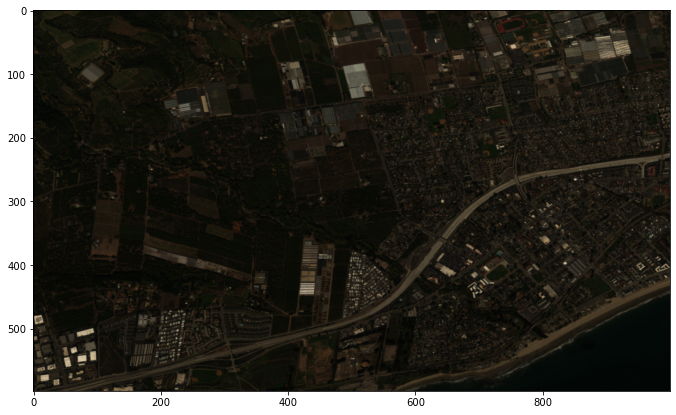

In [195]:
fig = plt.figure(figsize = (12, 7))
r = arr[:,:,54]
g = arr[:,:,34]
b = arr[:,:,16]
img = np.dstack((r, g, b))
plt.imshow(img);

In [204]:
arr_2 = []
for x in range(arr.shape[0]):
    for y in range(arr.shape[1]):
        arr_2.append(arr[x][y])

In [207]:
arr_2 = np.array(arr_2)

In [211]:
arr_2 = np.delete(arr_2, indicies,axis=1)

In [212]:
arr_2.shape

(598000, 335)

In [213]:
this_n_est = {'noise_covariance':np.diag(corrected_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
instrinsic_dimension = ID()
instrinsic_dimension(arr_2, this_n_est)

{'intrinsic_dimension': 36,
 'id_indicies': (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35]),),
 'rhos': array([2.65281296e-05, 2.02382435e-05, 8.19301131e-06, 1.95003657e-05,
        1.77721572e-05, 2.38861837e-05, 1.76947113e-05, 5.72193215e-06,
        2.65467403e-05, 1.66815697e-05, 2.97252351e-05, 1.37296693e-05,
        1.59271130e-05, 1.46573149e-05, 1.30760741e-05, 2.32176704e-05,
        2.16845730e-05, 2.42251005e-05, 2.21794807e-05, 1.59235803e-05,
        1.39113074e-05, 1.63399771e-05, 1.99734444e-05, 1.32889096e-05,
        1.53151913e-05, 1.08416076e-05, 1.20328207e-05, 1.12357067e-05,
        1.04601912e-05, 1.23583822e-05, 1.26175240e-05, 1.25883584e-05,
        1.12116541e-05, 9.55786181e-06, 1.03117425e-05, 9.53138814e-06,
        9.28004578e-06, 8.89023444e-06, 8.61578411e-06, 7.50210690e-06,
        7.37363098e-06, 6.97622933e-06, 6.77796176e-06

In [26]:
c = 0
negs = []
for x in range(arr.shape[0]):
    for y in range(arr.shape[1]):
        if min(np.array(arr[x][y])[indicies_2])<0 and min(np.array(arr[x][y])[indicies_2])>-100:
            c+=1
            negs.append(min(np.array(arr[x][y])))
print(c)

298196


In [27]:
print("mean:",np.mean(negs), "min:", min(negs), "median:", np.median(negs))

mean: -0.031000876813735805 min: -3.3156275749206543 median: -0.002896829857490957


In [28]:
355933/598000

0.5952056856187291

In [29]:
298196/598000

0.49865551839464883

In [34]:
# test out the hyper meer on this data and compare to kerry_noise

In [35]:
from Hyper_Meer import HyperMeer

In [36]:
test = HyperMeer(arr)

[ 0.62177325  0.08617448 -0.16875992 -0.61313049 -0.75436906 -0.75254621
 -0.86436504 -0.74411787]
l_u:  3
l_0:  3
Cannot determine noise
3
[ 0.62177325  0.08617448 -0.16875992 -0.61313049 -0.75436906 -0.75254621
 -0.86436504  5.14061011]
l_u:  3
l_0:  3
Cannot determine noise
3
[ 0.62177325  0.08617448 -0.16875992 -0.61313049 -0.75436906 -0.75254621
 -0.86436504  0.03369324]
l_u:  3
l_0:  3
Cannot determine noise
3
[ 0.62177325  0.08617448 -0.16875992 -0.61313049 -0.75436906 -0.75254621
 -0.86436504 -0.48764939]
l_u:  3
l_0:  3
Cannot determine noise
3
[ 0.62177325  0.08617448 -0.16875992 -0.61313049 -0.75436906 -0.75254621
 -0.86436504 -0.64333936]
l_u:  3
l_0:  3
Cannot determine noise
3
[ 0.62177325  0.08617448 -0.16875992 -0.61313049 -0.75436906 -0.75254621
 -0.86436504 -0.70449886]
l_u:  3
l_0:  3
Cannot determine noise
3
[ 0.62177325  0.08617448 -0.16875992 -0.61313049 -0.75436906 -0.75254621
 -0.86436504 -0.78096956]
l_u:  3
l_0:  3
Cannot determine noise
3
[ 0.62177325  0.0861

KeyboardInterrupt: 

In [ ]:
test

In [6]:
import os
from osgeo import gdal
import sys

In [7]:
def pixel_geo_coords(dx,dy, raster):
    px = raster.GetGeoTransform()[0]
    py = raster.GetGeoTransform()[3]
    rx = raster.GetGeoTransform()[1]
    ry = raster.GetGeoTransform()[5]
    x = dx*rx + px
    y = dy*ry + py
    return x,y

In [8]:
os.listdir("/home/makiper/Data/surface_types/")

['rocks',
 '.ipynb_checkpoints',
 'roofs',
 'parking_lots',
 'cover_raster.tif',
 'vrf_input_files.txt',
 'raster_series.vrt',
 'cover_extraction_series.csv',
 'cover_raster_series.tif',
 'cover_raster_parking_lots.tif',
 'cover_extraction_parking_lots.csv',
 'cover_raster_roof_tops.tif',
 'cover_extraction_roof_tops.csv',
 'cover_raster_rocks.tif',
 'cover_extraction_rocks.csv',
 'serpentine',
 'cover_raster_serpentine.tif',
 'cover_extraction_serpentine.csv']

In [9]:
raster = gdal.Open("/home/makiper/Data/surface_types/cover_raster_serpentine.tif")
print(f"X: {raster.RasterXSize}, Y: {raster.RasterYSize}, Z: {raster.RasterCount}")

X: 13739, Y: 12023, Z: 1


In [10]:
# CAN DO ABOVE OR BELOW
step_size = 50
valid_array = []
index_coords = []
utm_coords = []
for x in range(0, raster.RasterXSize-step_size, step_size):
    for y in range(0, raster.RasterYSize-step_size, step_size):
        arr = raster.ReadAsArray(xoff=x, yoff=y, xsize=step_size, ysize=step_size)
        try:
            if abs(sum(sum(arr))) != step_size*step_size:
                # TODO: DFS alg on extracting exact shape
                
                index_coords.append({'xoff':x, 'yoff':y, 'step':step_size})
                upper_left_coords, lower_right_coords = pixel_geo_coords(x, y, raster), pixel_geo_coords(x+step_size, y+step_size, raster)
                utm_coords.append((upper_left_coords, lower_right_coords))
                valid_array.append(arr)
        except Exception:
            raise Exception

In [11]:
utm_coords[:10]

[((770470.0, 3848615.0), (770720.0, 3848365.0)),
 ((771470.0, 3846865.0), (771720.0, 3846615.0)),
 ((774220.0, 3848365.0), (774470.0, 3848115.0)),
 ((774470.0, 3848365.0), (774720.0, 3848115.0)),
 ((774470.0, 3848115.0), (774720.0, 3847865.0)),
 ((775220.0, 3844615.0), (775470.0, 3844365.0)),
 ((775470.0, 3843865.0), (775720.0, 3843615.0)),
 ((775720.0, 3844115.0), (775970.0, 3843865.0)),
 ((775720.0, 3843865.0), (775970.0, 3843615.0)),
 ((775720.0, 3843615.0), (775970.0, 3843365.0))]

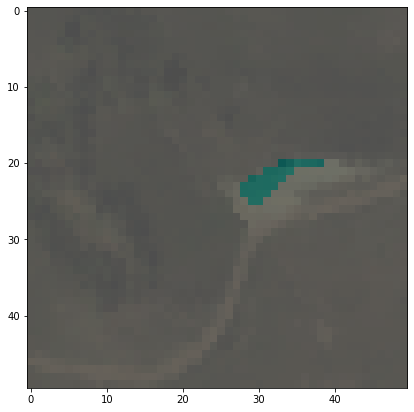

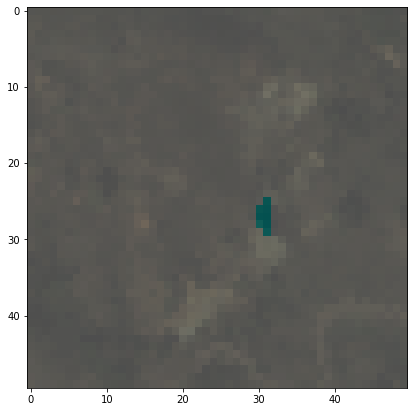

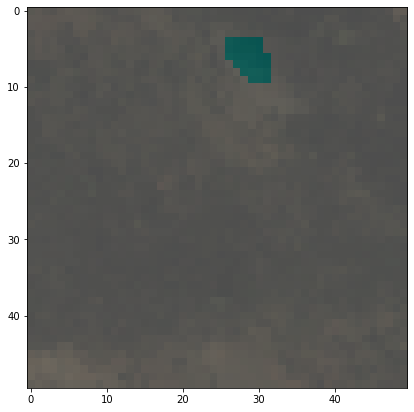

In [13]:
rfls = gdal.Open("/beegfs/scratch/makiper/Mosaics/flight_products/20220224/box_mosaics/box_rfl_phase")

overlay = True

# def flip(arr):
#     new_arr = 

for i, coords in enumerate(index_coords[:3]):
    this_arr = rfls.ReadAsArray(xoff=coords['xoff'], yoff=coords['yoff'], xsize=coords['step'], ysize=coords['step'])
    this_arr = np.array(this_arr).T
    this_arr = np.fliplr(this_arr)
    this_arr = np.rot90(this_arr, k=1, axes=(0,1))
    
    fig = plt.figure(figsize = (12, 7))
    r = this_arr[:,:,54]
    g = this_arr[:,:,34]
    b = this_arr[:,:,16]
    img = np.dstack((r, g, b))
    plt.imshow(img);
    
    if overlay:
        c = abs(valid_array[i])
        z = np.ones((valid_array[i].shape[0],valid_array[i].shape[1]))
        img = np.dstack((c, z, z))
        plt.imshow(img, alpha = 0.3);

In [14]:
coords = index_coords[0]
this_arr = rfls.ReadAsArray(xoff=coords['xoff'], yoff=coords['yoff'], xsize=coords['step'], ysize=coords['step'])
this_arr = np.array(this_arr).T
this_arr = np.fliplr(this_arr)
this_arr = np.rot90(this_arr, k=1, axes=(0,1))

indicies = np.where(valid_array[0] == 0)

In [15]:
this_arr[indicies].shape

(35, 425)

In [12]:
import concurrent

def pixel_geo_coords(dx,dy, raster):
    px = raster.GetGeoTransform()[0]
    py = raster.GetGeoTransform()[3]
    rx = raster.GetGeoTransform()[1]
    ry = raster.GetGeoTransform()[5]
    x = dx*rx + px
    y = dy*ry + py
    return x,y

def get_coords(file):
    raster = gdal.Open(file)

    step_size = 50
    valid_array = []
    index_coords = []
    utm_coords = []
    for x in range(0, raster.RasterXSize-step_size, step_size):
        for y in range(0, raster.RasterYSize-step_size, step_size):
            arr = raster.ReadAsArray(xoff=x, yoff=y, xsize=step_size, ysize=step_size)
            try:
                if abs(sum(sum(arr))) != step_size*step_size:
                    # TODO: DFS alg on extracting exact shape

                    index_coords.append({'xoff':x, 'yoff':y, 'step':step_size})
                    upper_left_coords, lower_right_coords = pixel_geo_coords(x, y, raster), pixel_geo_coords(x+step_size, y+step_size, raster)
                    utm_coords.append((upper_left_coords, lower_right_coords))
                    valid_array.append(arr)
            except Exception:
                raise Exception
                
    return index_coords, valid_array


def thread_rfl(map_indicies):
    start_index, end_index = map_indicies['indicies']
    index_coords = map_indicies['index_coords']
    valid_array = map_indicies['valid_array']
    gdals = map_indicies['gdals']
    
    dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
    this_complete_pixels = []
    step_size = 50
    
    complete_pixels = dict(zip(dates, [np.array([]) for d in dates]))
    for i, coords in enumerate(index_coords[start_index: end_index]):
        i = i + start_index
        valid_indicies = np.where(valid_array[i] == 0)
        
        mask = np.ma.masked_where(valid_array[i] != -1, valid_array[i]).mask

        rfls = []
        for j, date in enumerate(dates):
            rfl = gdals[j].ReadAsArray(xoff=coords['xoff'], yoff=coords['yoff'], xsize=step_size, ysize=step_size)
            # rfl = index_reshape(rfl)
            rfl = np.array(rfl).T
            rfl = np.fliplr(rfl)
            rfl = np.rot90(rfl, k=1, axes=(0,1))

            
            rfl = rfl[valid_indicies]

            if len(complete_pixels[date]) == 0:
                complete_pixels[date] = rfl
            else:
                complete_pixels[date] = np.concatenate([complete_pixels[date], rfl], axis=0)
            rfls.append(rfl)


#         for x in range(mask.shape[0]):
#             for y in range(mask.shape[1]):
#                 if mask[x][y]:

#                     this_temporal_pixel = []
#                     complete_pixel = True

#                     for j, date in enumerate(dates):
#                         try:
#                             this_rfl = rfls[j][x][y]
#                             # this_temporal_pixel.append(this_rfl)
#                             if len(complete_pixels[date]) == 0:
#                                 complete_pixels[date] = [this_rfl]
#                             else:
#                                 complete_pixels[date] = np.concatenate([complete_pixels[date], [this_rfl]], axis=0)
#                         except Exception:
#                             print(j, x, y)
#                             print(date)
#                             print(start_index, end_index)
#                             print(mask.shape)
#                             raise Exception
            
        print(str(i)+"/"+str(len(index_coords)))
        
    return complete_pixels


def get_rfls(file):
    
    index_coords, valid_array = get_coords(file)
    print("Obtained Coords")
    
    dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
    complete_pixels = []

    gdals = []
    for date in dates:
        gdals.append(gdal.Open(f"/beegfs/scratch/makiper/Mosaics/flight_products/{date}/box_mosaics/box_rfl_phase"))
        
    with concurrent.futures.ThreadPoolExecutor() as executer:
        index_step = 10
        indicies = [(index, index+index_step if index+index_step < len(index_coords) else len(index_coords)) for index in range(0, len(index_coords), index_step)]
        print(indicies)
        enter_list = [{'indicies':i, 'index_coords':index_coords, 'valid_array':valid_array, 'gdals':gdals} for i in indicies]
        
        results = executer.map(thread_rfl, enter_list)

        for result in results:
            complete_pixels.append(result)
        
    return complete_pixels
                
    # for i, coords in enumerate(index_coords):
    #     this_arr = rfls.ReadAsArray(xoff=coords['xoff'], yoff=coords['yoff'], xsize=coords['step'], ysize=coords['step'])
    #     this_arr = np.array(this_arr).T
    #     this_arr = np.fliplr(this_arr)
    #     this_arr = np.rot90(this_arr, k=1, axes=(0,1))
        
        
        
    

In [63]:
rock_path = "/home/makiper/Data/surface_types/cover_raster_rocks.tif"
parking_lot_path = "/home/makiper/Data/surface_types/cover_raster_parking_lots.tif"
roof_top_path = "/home/makiper/Data/surface_types/cover_raster_roof_tops.tif"

In [64]:
rock_rfls = get_rfls(rock_path)

Obtained Coords
[(0, 10), (10, 20), (20, 30), (30, 37)]
0/37
10/37
30/37
11/37
1/37
31/37
20/37
12/37
2/37
32/37
21/37
13/37
3/37
33/37
22/37
4/37
34/37
23/37
5/37
14/37
35/37
24/37
6/37
15/37
36/37
25/37
7/37
16/37
26/37
8/37
17/37
27/37
9/37
18/37
28/37
19/37
29/37


In [65]:
total_rfls_rock = {}

for item in rock_rfls:
    for date in list(rock_rfls[0].keys()):
        if date not in total_rfls_rock.keys():
            total_rfls_rock[date] = item[date]
        else:
            total_rfls_rock[date] = np.concatenate([total_rfls_rock[date], item[date]], axis = 0)

In [66]:
total_rfls_rock['20220224'].shape

(4028, 425)

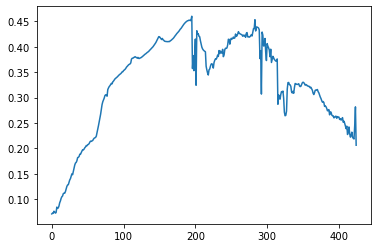

In [67]:
plt.plot(np.mean(total_rfls_rock['20220224'], axis=0));

In [119]:
bad_rfls = []
for date in total_rfls_rock.keys():
    for i, rfl in enumerate(total_rfls_rock[date]):
        if -9999 in rfl:
            if i not in bad_rfls and len(np.where(rfl<0)[0])>5:
                bad_rfls.append(i)
            else:
                indicies = np.where(rfl<0)[0]
                for ind in indicies:
                    if ind-1>0 and ind+1<425:
                        avg = np.mean([rfl[ind-1], rfl[ind+1]])
                        rfl[ind] = avg
                        total_rfls_rock[date][i] = rfl
                
len(bad_rfls), total_rfls_rock['20220224'].shape

(1870, (4028, 425))

In [120]:
with open("/home/makiper/Notebooks/true_rock_rfls_2_corrected.pickle", "wb") as f:
    pickle.dump(total_rfls_rock, f)

In [69]:
parking_lot_rfls = get_rfls(parking_lot_path)

Obtained Coords
[(0, 10), (10, 20), (20, 23)]
20/23
10/23
0/23
21/23
11/23
1/23
2/23
12/23
22/23
3/23
13/23
4/23
14/23
5/23
15/23
6/23
16/23
7/23
17/23
8/23
18/23
9/23
19/23


In [70]:
total_rfls_parking_lot = {}

for item in parking_lot_rfls:
    for date in list(parking_lot_rfls[0].keys()):
        if date not in total_rfls_parking_lot.keys():
            total_rfls_parking_lot[date] = item[date]
        else:
            total_rfls_parking_lot[date] = np.concatenate([total_rfls_parking_lot[date], item[date]], axis = 0)

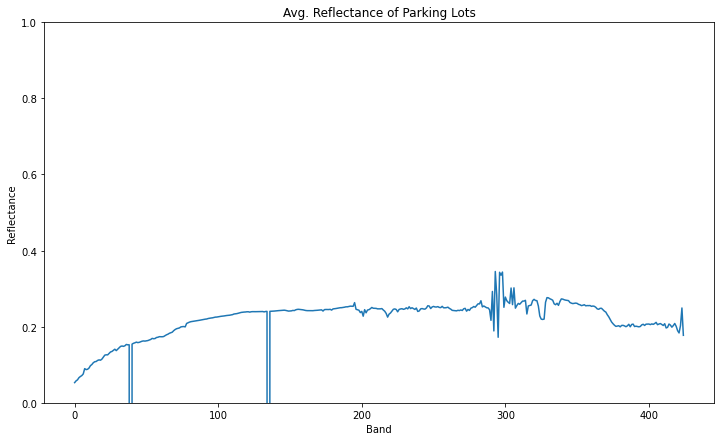

In [76]:
plt.figure(figsize=(12, 7))
plt.ylim(0, 1);
plt.title("Avg. Reflectance of Parking Lots");
plt.xlabel("Band");
plt.ylabel("Reflectance");
plt.plot(np.mean(total_rfls_parking_lot['20220224'], axis=0));

In [116]:
bad_rfls = []
for date in total_rfls_parking_lot.keys():
    for i, rfl in enumerate(total_rfls_parking_lot[date]):
        if -9999 in rfl:
            if i not in bad_rfls and len(np.where(rfl<0)[0])>6:
                bad_rfls.append(i)
            else:
                indicies = np.where(rfl<0)[0]
                for ind in indicies:
                    if ind-1>0 and ind+1<425:
                        avg = np.mean([rfl[ind-1], rfl[ind+1]])
                        rfl[ind] = avg
                        total_rfls_parking_lot[date][i] = rfl
                
len(bad_rfls), total_rfls_parking_lot['20220224'].shape

(713, (1109, 425))

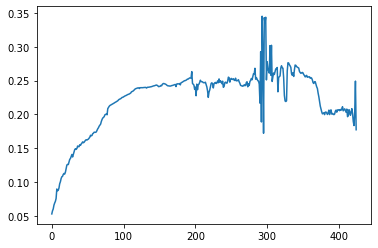

In [117]:
# plt.plot([i for i in total_rfls_parking_lot['20220224'][550] if i >0]);
plt.plot(np.mean(total_rfls_parking_lot['20220224'], axis=0));

In [118]:
with open("/home/makiper/Notebooks/true_parking_lot_rfls_2_corrected.pickle", "wb") as f:
    pickle.dump(total_rfls_parking_lot, f)

In [53]:
roof_top_rfls = get_rfls(roof_top_path)

Obtained Coords
[(0, 10), (10, 20), (20, 30), (30, 36)]
20/36
10/36
30/36
0/36
21/36
11/36
1/36
31/36
12/36
22/36
2/36
3/36
13/36
23/36
32/36
4/36
14/36
24/36
33/36
5/36
15/36
25/36
34/36
16/36
26/36
6/36
17/36
27/36
35/36
7/36
18/36
8/36
19/36
28/36
9/36
29/36


In [127]:
total_rfls_roof_top = {}

for item in roof_top_rfls:
    for date in list(roof_top_rfls[0].keys()):
        if date not in total_rfls_roof_top.keys():
            total_rfls_roof_top[date] = item[date]
        else:
            total_rfls_roof_top[date] = np.concatenate([total_rfls_roof_top[date], item[date]], axis = 0)

In [128]:
bad_rfls = []
for date in total_rfls_roof_top.keys():
    for i, rfl in enumerate(total_rfls_roof_top[date]):
        if -9999 in rfl:
            if i not in bad_rfls and len(np.where(rfl<0)[0])>5:
                bad_rfls.append(i)
            else:
                indicies = np.where(rfl<0)[0]
                for ind in indicies:
                    if ind-1>0 and ind+1<425:
                        avg = np.mean([rfl[ind-1], rfl[ind+1]])
                        rfl[ind] = avg
                        total_rfls_roof_top[date][i] = rfl
                
len(bad_rfls), total_rfls_roof_top['20220224'].shape

(1406, (1842, 425))

In [131]:
total_rfls_roof_top.keys()

dict_keys(['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529'])

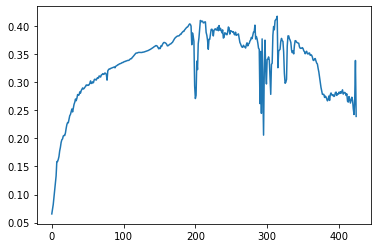

In [144]:
plt.plot(np.mean(total_rfls_roof_top['20220224'], axis=0));

In [123]:
with open("/home/makiper/Notebooks/true_roof_top_rfls_2_corrected.pickle", "wb") as f:
    pickle.dump(total_rfls_roof_top, f)

In [43]:
import concurrent

def pixel_geo_coords(dx,dy, raster):
    px = raster.GetGeoTransform()[0]
    py = raster.GetGeoTransform()[3]
    rx = raster.GetGeoTransform()[1]
    ry = raster.GetGeoTransform()[5]
    x = dx*rx + px
    y = dy*ry + py
    return x,y

def get_coords(file):
    raster = gdal.Open(file)

    step_size = 50
    valid_array = []
    index_coords = []
    utm_coords = []
    for x in range(0, raster.RasterXSize-step_size, step_size):
        for y in range(0, raster.RasterYSize-step_size, step_size):
            arr = raster.ReadAsArray(xoff=x, yoff=y, xsize=step_size, ysize=step_size)
            try:
                if abs(sum(sum(arr))) != step_size*step_size:
                    # TODO: DFS alg on extracting exact shape

                    index_coords.append({'xoff':x, 'yoff':y, 'step':step_size})
                    upper_left_coords, lower_right_coords = pixel_geo_coords(x, y, raster), pixel_geo_coords(x+step_size, y+step_size, raster)
                    utm_coords.append((upper_left_coords, lower_right_coords))
                    valid_array.append(arr)
            except Exception:
                raise Exception
                
    return index_coords, valid_array


def thread_rfl(map_indicies):
    start_index, end_index = map_indicies['indicies']
    index_coords = map_indicies['index_coords']
    valid_array = map_indicies['valid_array']
    gdals = map_indicies['gdals']
    
    dates = ['20220224']
    this_complete_pixels = []
    step_size = 50
    
    complete_pixels = dict(zip(dates, [np.array([]) for d in dates]))
    for i, coords in enumerate(index_coords[start_index: end_index]):
        i = i + start_index
        valid_indicies = np.where(valid_array[i] == 0)
        
        mask = np.ma.masked_where(valid_array[i] != -1, valid_array[i]).mask

        rfls = []
        for j, date in enumerate(dates):
            rfl = gdals[j].ReadAsArray(xoff=coords['xoff'], yoff=coords['yoff'], xsize=step_size, ysize=step_size)
            # rfl = index_reshape(rfl)
            rfl = np.array(rfl).T
            rfl = np.fliplr(rfl)
            rfl = np.rot90(rfl, k=1, axes=(0,1))
            
            fig = plt.figure(figsize = (12, 7))
            print(rfl.shape)
            r = rfl[:,:,54]
            g = rfl[:,:,34]
            b = rfl[:,:,16]
            img = np.dstack((r, g, b))
            plt.imshow(img);

            c = abs(valid_array[i])
            z = np.ones((valid_array[i].shape[0],valid_array[i].shape[1]))
            img = np.dstack((c, z, z))
            plt.imshow(img, alpha = 0.3);

            
            rfl = rfl[valid_indicies]

            if len(complete_pixels[date]) == 0:
                complete_pixels[date] = rfl
            else:
                complete_pixels[date] = np.concatenate([complete_pixels[date], rfl], axis=0)
            rfls.append(rfl)
            
            
            
        print(str(i)+"/"+str(len(index_coords)))
        
    return complete_pixels


def get_rfls(file):
    
    index_coords, valid_array = get_coords(file)
    print("Obtained Coords")
    
    dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
    complete_pixels = []

    gdals = []
    for date in dates:
        gdals.append(gdal.Open(f"/beegfs/scratch/makiper/Mosaics/flight_products/{date}/box_mosaics/box_rfl_phase"))
        
    index_step = 10
    indicies = [(index, index+index_step if index+index_step < len(index_coords) else len(index_coords)) for index in range(0, len(index_coords), index_step)][:2]
    enter_list = [{'indicies':i, 'index_coords':index_coords, 'valid_array':valid_array, 'gdals':gdals} for i in indicies]
    
    return_r = []
    for e in enter_list:
        return_r.append(thread_rfl(e))
        
    return return_r
        
#     with concurrent.futures.ThreadPoolExecutor() as executer:
#         index_step = 10
#         indicies = [(index, index+index_step if index+index_step < len(index_coords) else len(index_coords)) for index in range(0, len(index_coords), index_step)][:2]
#         print(indicies)
#         enter_list = [{'indicies':i, 'index_coords':index_coords, 'valid_array':valid_array, 'gdals':gdals} for i in indicies]
        
#         results = executer.map(thread_rfl, enter_list)

#         for result in results:
#             complete_pixels.append(result)
        
#     return complete_pixels
        
        
        
    

Obtained Coords
(50, 50, 425)
0/36
(50, 50, 425)
1/36
(50, 50, 425)
2/36
(50, 50, 425)
3/36
(50, 50, 425)
4/36
(50, 50, 425)
5/36
(50, 50, 425)
6/36
(50, 50, 425)
7/36
(50, 50, 425)
8/36
(50, 50, 425)
9/36
(50, 50, 425)
10/36
(50, 50, 425)
11/36
(50, 50, 425)
12/36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50, 50, 425)
13/36
(50, 50, 425)
14/36
(50, 50, 425)
15/36
(50, 50, 425)
16/36
(50, 50, 425)
17/36
(50, 50, 425)
18/36
(50, 50, 425)
19/36


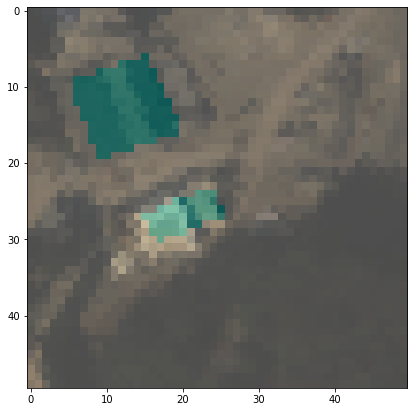

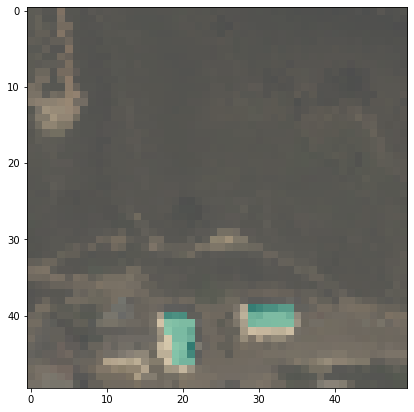

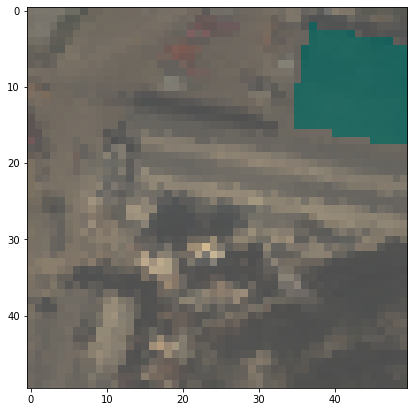

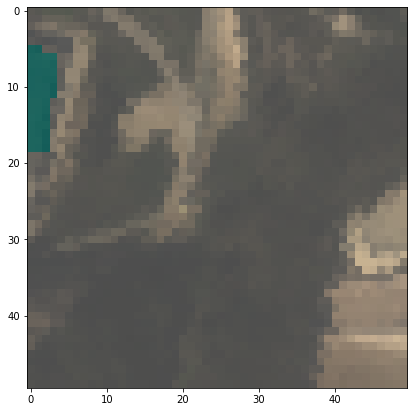

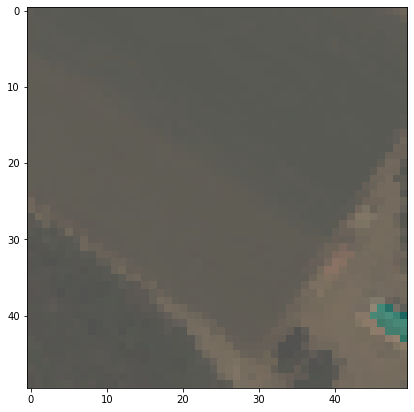

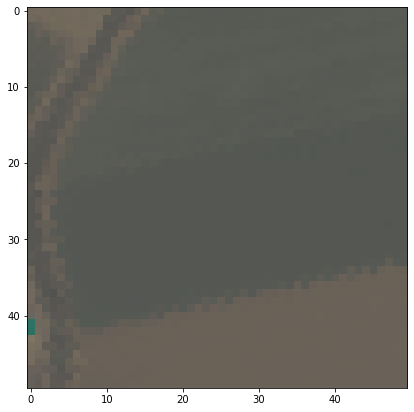

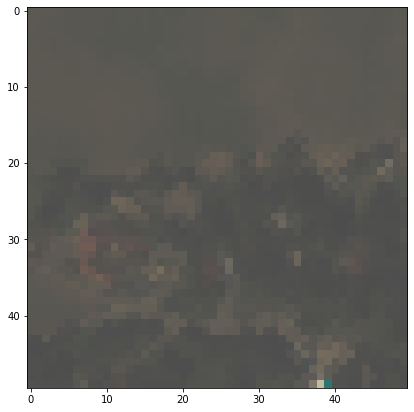

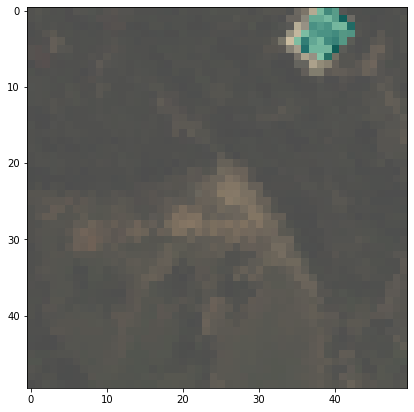

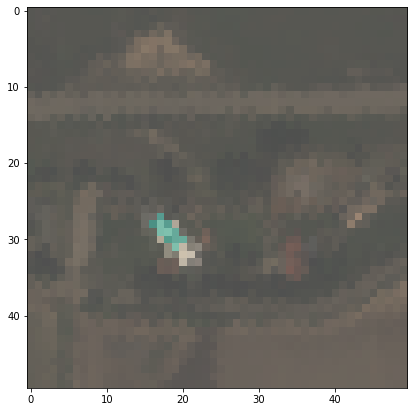

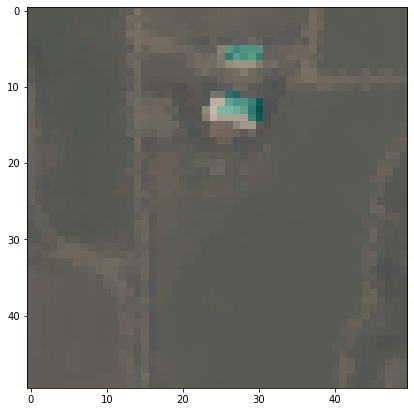

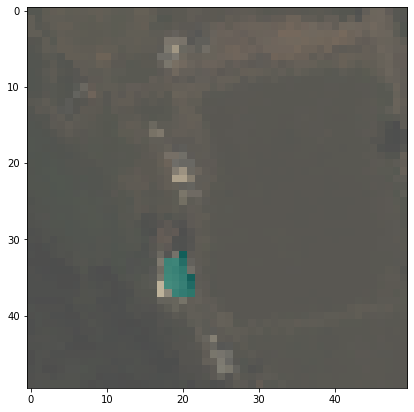

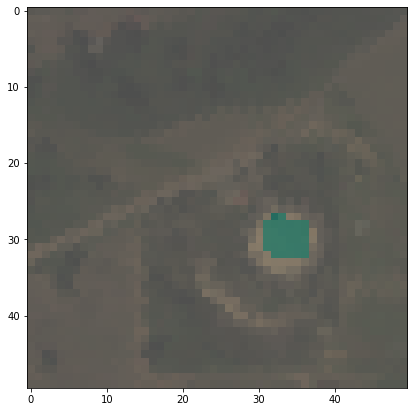

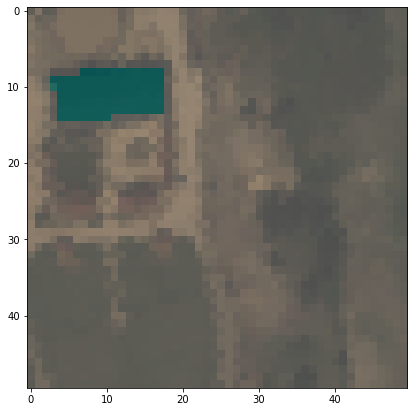

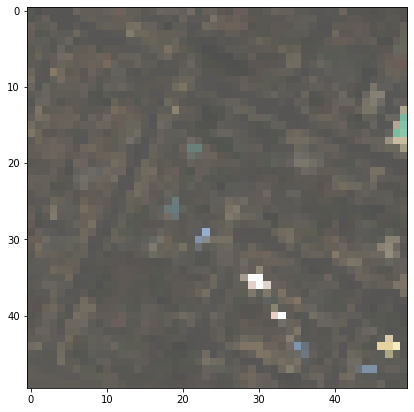

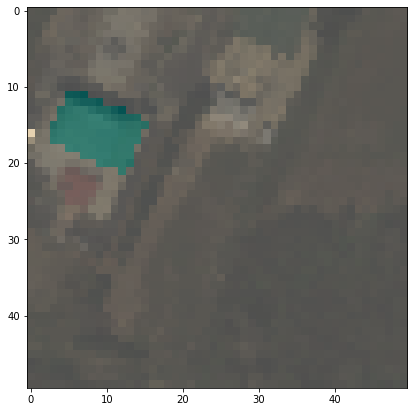

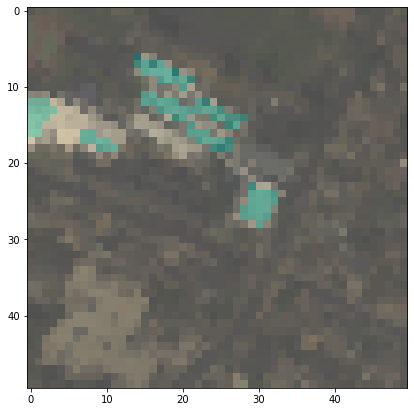

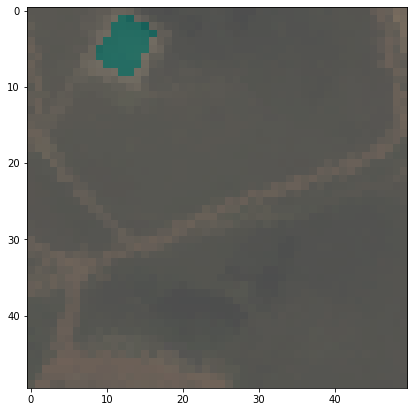

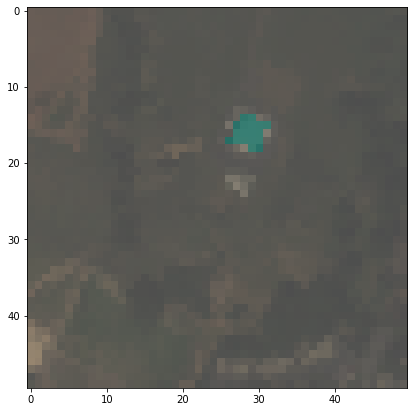

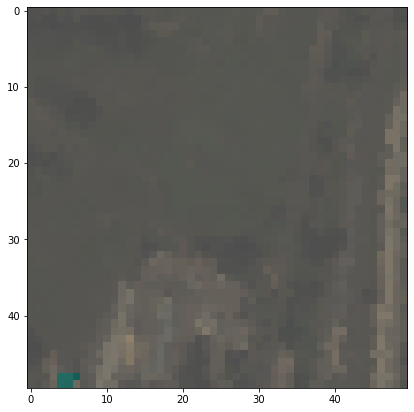

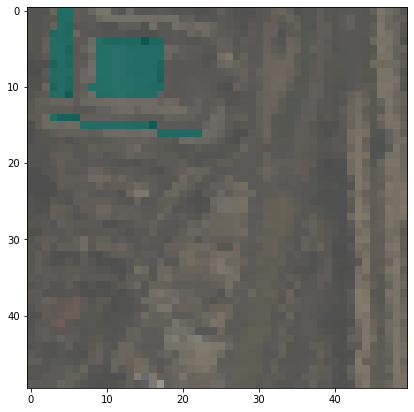

In [44]:
roof_top_rfls = get_rfls(roof_top_path)

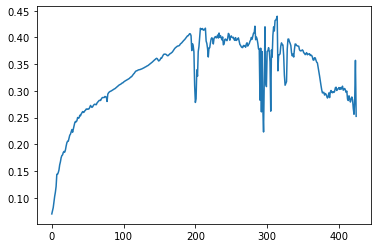

In [50]:
arr = np.concatenate([roof_top_rfls[0]['20220224'], roof_top_rfls[1]['20220224']], axis=0)
plt.plot(np.mean(arr, axis = 0));

In [74]:
np.concatenate([np.linspace(start=1.01, stop=1.03, num=2), [np.random.uniform(low=1.01, high=1.03) for i in range(30)]])

array([1.01      , 1.03      , 1.02476336, 1.02023219, 1.02145634,
       1.01698778, 1.01091832, 1.01147493, 1.01525845, 1.02318895,
       1.02971161, 1.02460824, 1.01421867, 1.0281765 , 1.01812458,
       1.02442614, 1.01067281, 1.02397632, 1.0117479 , 1.01045462,
       1.02495231, 1.0258698 , 1.02561085, 1.02018011, 1.01194321,
       1.01134672, 1.02766812, 1.02402187, 1.02072628, 1.01276434,
       1.01124664, 1.02827557])

In [116]:
np.concatenate([np.linspace(start=1.01, stop=1.03, num=3), np.linspace(start=-1.03, stop=-1.01, num=3)])

array([ 1.01,  1.02,  1.03, -1.03, -1.02, -1.01])

In [115]:
[1+i if i>0 else -1+i for i in [np.random.uniform(low=-0.03, high=0.03) for i in range(corrected_noise.shape[0])]]

-0.026678136119610823

In [126]:
# uniformly change the noise matrix:
lin = np.concatenate([np.linspace(start=1.01, stop=1.03, num=3), np.linspace(start=-1.03, stop=-1.01, num=3)])
for i, p in enumerate(lin):  
    mat = corrected_noise*p
    with open(f"/home/makiper/Bootstrap/noise_matrices/noise_matrix_constant_{i}.pickle", "wb") as f:
        pickle.dump({'noise_matrix':mat, "multiple":p}, f)

In [121]:
# randomly change the noise matrix
num_trials = 6
for t in range(num_trials):
    r = [np.random.uniform(low=1.01, high=1.03) for i in range(corrected_noise.shape[0])]
    mat = corrected_noise*r
    with open(f"/home/makiper/Bootstrap/noise_matrices/noise_matrix_random_{t}.pickle", "wb") as f:
        pickle.dump({'noise_matrix':mat, "multiple":r}, f)

In [129]:
noise_mat_path = "/home/makiper/Bootstrap/noise_matrices"
for noise_mat in os.listdir("/home/makiper/Bootstrap/noise_matrices"):
    f = open(os.path.join(noise_mat_path, noise_mat), "rb")
    n = pickle.load(f)
    noise, multiples = n['noise_matrix'], n ['multiple']

In [23]:
high_p, low_p = 0.2, 0.01

In [24]:
r = [np.random.uniform(low=low_p, high=high_p) for i in range(corrected_noise.shape[0])]
mat = corrected_noise*r
mat = corrected_noise + mat
with open(f"/home/makiper/Bootstrap/noise_matrices/noise_matrix_pos_breaking_20.pickle", "wb") as f:
    pickle.dump({'noise_matrix':mat, "multiple":r}, f)

In [25]:
r = [np.random.uniform(low=-high_p, high=-low_p) for i in range(corrected_noise.shape[0])]
mat = corrected_noise*r
mat = corrected_noise + mat
with open(f"/home/makiper/Bootstrap/noise_matrices/noise_matrix_neg_breaking_20.pickle", "wb") as f:
    pickle.dump({'noise_matrix':mat, "multiple":r}, f)

In [26]:
r = [np.random.uniform(low=-high_p, high=high_p) for i in range(corrected_noise.shape[0])]
mat = corrected_noise*r
mat = corrected_noise + mat
with open(f"/home/makiper/Bootstrap/noise_matrices/noise_matrix_random_breaking_20.pickle", "wb") as f:
    pickle.dump({'noise_matrix':mat, "multiple":r}, f)

In [11]:
# import Kerry's noise matrix
noise_2 = open("SHIFT_noise_M_allbands_2.txt", "rb").read()
noise_2 = str(noise_2).replace("b","").replace("'", "").replace("'", "")
noise_2 = np.array([float(i) for i in str(noise_2).split(",") if i != ''])

In [2]:
import pickle

In [8]:
with open("true_rock_rfls.pickle", "rb") as f:
    rock_rfls = pickle.load(f)

with open("true_roof_top_2_rfls.pickle", "rb") as f:
    roof_top_rfls = pickle.load(f)
    
with open("true_parking_lot_3_rfls.pickle", "rb") as f:
    parking_lot_rfls = pickle.load(f)
    
with open("true_grassland_rfls.pickle", "rb") as f:
    grassland_rfls = pickle.load(f)
    
with open("true_shrub_rfls.pickle", "rb") as f:
    shrub_rfls = pickle.load(f)
    
with open("true_tree_rfls.pickle", "rb") as f:
    tree_rfls = pickle.load(f)

In [9]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)

cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indices = np.where(cond_1 | cond_2 | cond_3 | cond_4)[0]
good_indices = [i for i in range(425) if i not in list(bad_indices)]

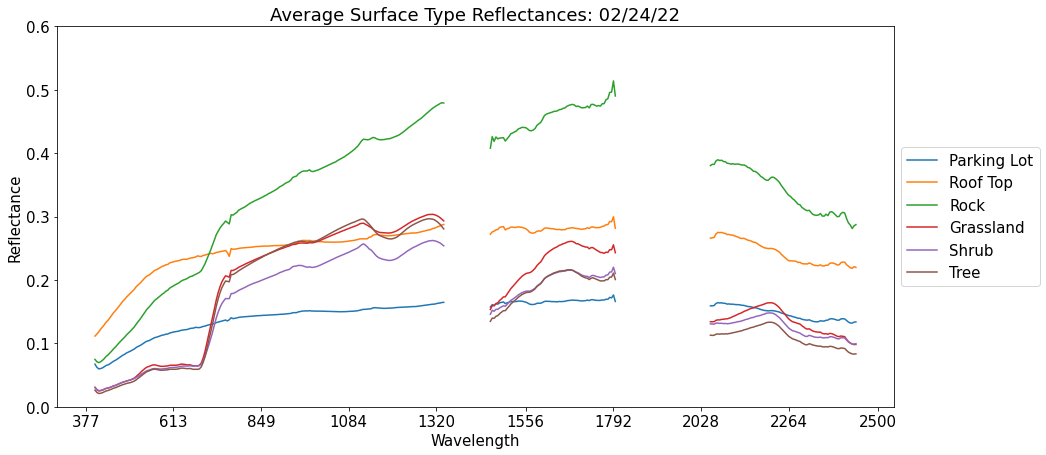

In [16]:
fig = plt.figure(figsize=(15,7))

date = "20220224"
rfls = [parking_lot_rfls,roof_top_rfls, rock_rfls, grassland_rfls, shrub_rfls, tree_rfls]
labels = ["Parking Lot", "Roof Top", "Rock", "Grassland", "Shrub", "Tree"]
for j,st in enumerate(rfls):
    mean_rfls = np.mean(st[date], axis = 0)
    plot_this = []
    for i in range(425):
        if i in good_indices:
            plot_this.append(mean_rfls[i])
        else:
            plot_this.append(np.nan)
            
    plt.plot(plot_this, label = labels[j]);
    
n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]

plt.xticks(x_t0, x_t1)
plt.title("Average Surface Type Reflectances: 02/24/22", fontsize=18);
plt.xlabel("Wavelength", fontsize=15);
plt.ylabel("Reflectance", fontsize=15);
plt.ylim(0,0.6);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15);

In [40]:
with open("true_whole_scene_rfls.pickle", "wb") as f:
    pickle.dump(all_rfls, f)

In [54]:
import re
enitre_mosaic = {}

for file in os.listdir("../Clustering/"):
    if ".pickle" in file:
        date = re.findall("\d*", file)[0]
        with open("../Clustering/"+file, 'rb') as f:
            enitre_mosaic[date] = pickle.load(f)
   

In [55]:
with open("true_entire_mosaic_rfls.pickle", "wb") as f:
    pickle.dump(enitre_mosaic, f)

In [36]:
def create_series(dates_list, series_dict):
    
    # return the bad indices too
    bad_indices = []
    for date in series_dict.keys():
        for i, rfl in enumerate(series_dict[date]):
            if i not in bad_indices and -9999 in list(rfl):
                bad_indices.append(i)
    
    series = []
    remove_bands = True

    for dates, mean_freq in dates_list:
        master = None
        for d in dates:
            ds = series_dict[d]
            if remove_bands:
                ds = remove_bands_f(ds) 
                # ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NEW NOISE MATRIX
                
                norm = True
                if norm:
                    ds = np.array([j/(sum([i**2 for i in j])**0.5) for j in ds])

            if master is None:
                master = ds
            else:
                master = np.concatenate([master, ds], axis=1)
        series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})
    return series, bad_indices

In [34]:
temp_series = pickle.load(open("/home/makiper/Notebooks/true_tree_rfls.pickle", "rb"))

In [29]:
with open("/home/makiper/Notebooks/true_parking_lot_rfls_2_corrected.pickle", "rb") as f:
    temp_dict = pickle.load(f)

num_dates = len(temp_dict.keys())
series_dates = [create_raw_time_series(temp_dict, i, remove_bands=False) for i in range(num_dates)]

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Differenc

In [30]:
bad_indices = []
for date in temp_series.keys():
    for i, rfl in enumerate(temp_series[date]):
        if i not in bad_indices and -9999 in list(rfl):
            bad_indices.append(i)

In [31]:
bad_indices.sort()
len(bad_indices)

1870

In [32]:
np.delete(temp_series['20220224'], bad_indices, axis=0).shape

(2158, 425)

In [37]:
series, bad_i = create_series(series_dates, temp_series)

In [4]:
with open("/home/makiper/Bootstrap_2/parking_lot_3_mining.pickle", "rb") as f:
    parking_lot = pickle.load(f)
with open("/home/makiper/Bootstrap_2/roof_top_2_mining.pickle", "rb") as f:
    roof_top = pickle.load(f)
with open("/home/makiper/Bootstrap_2/rock_mining.pickle", "rb") as f:
    rock = pickle.load(f)
with open("/home/makiper/Bootstrap_2/grassland_mining.pickle", "rb") as f:
    grassland = pickle.load(f)
with open("/home/makiper/Bootstrap_2/shrub_mining.pickle", "rb") as f:
    shrub = pickle.load(f)
with open("/home/makiper/Bootstrap_2/tree_mining.pickle", "rb") as f:
    tree = pickle.load(f)
    
    
with open("/home/makiper/Bootstrap_2/parking_lot_3_mining_10x.pickle", "rb") as f:
    parking_lot_10x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/roof_top_2_mining_10x.pickle", "rb") as f:
    roof_top_10x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/rock_mining_10x.pickle", "rb") as f:
    rock_10x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/grassland_mining_10x.pickle", "rb") as f:
    grassland_10x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/shrub_mining_10x.pickle", "rb") as f:
    shrub_10x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/tree_mining_10x.pickle", "rb") as f:
    tree_10x = pickle.load(f)
    
with open("/home/makiper/Bootstrap_2/parking_lot_3_mining_100x.pickle", "rb") as f:
    parking_lot_100x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/roof_top_2_mining_100x.pickle", "rb") as f:
    roof_top_100x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/rock_mining_100x.pickle", "rb") as f:
    rock_100x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/grassland_mining_100x.pickle", "rb") as f:
    grassland_100x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/shrub_mining_100x.pickle", "rb") as f:
    shrub_100x = pickle.load(f)
with open("/home/makiper/Bootstrap_2/tree_mining_100x.pickle", "rb") as f:
    tree_100x = pickle.load(f)

In [5]:
np.where(parking_lot[i]['eigen_values'] < parking_lot[i]['rhos']*parking_lot[i]['r'])[0][0]

NameError: name 'i' is not defined

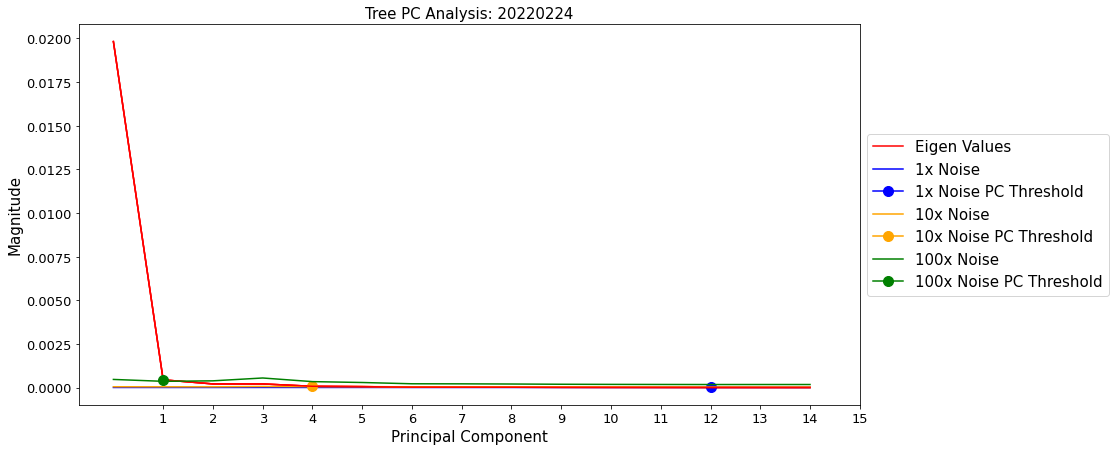

In [44]:
i = 0

this_1x_series = tree
this_10x_series = tree_10x
this_100x_series = tree_100x
title = "Tree"
date = ["20220224"][i]

threshold_1 = np.where(this_1x_series[i]['eigen_values'] < this_1x_series[i]['rhos']*this_1x_series[i]['r'])[0][0]
threshold_2 = np.where(this_10x_series[i]['eigen_values'] < this_10x_series[i]['rhos']*this_10x_series[i]['r'])[0][0]
threshold_3 = np.where(this_100x_series[i]['eigen_values'] < this_100x_series[i]['rhos']*this_100x_series[i]['r'])[0][0]
n = max(threshold_1, threshold_2, threshold_3) + 2

fig = plt.figure(figsize=(14,7))

plt.plot(this_1x_series[i]['eigen_values'][:n], color="red", label="Eigen Values"); # get the magnitudes
plt.plot(this_1x_series[i]['rhos'][:n]*this_1x_series[i]['r'], color="blue", label="1x Noise");
plt.plot(threshold_1-1, this_1x_series[i]['eigen_values'][threshold_1-1], marker="o", markersize=10, color="blue", label="1x Noise PC Threshold");

plt.plot(this_10x_series[i]['eigen_values'][:n], color="red"); # get the magnitudes
plt.plot(this_10x_series[i]['rhos'][:n]*this_10x_series[i]['r'], color="orange", label="10x Noise");
plt.plot(threshold_2-1, this_10x_series[i]['eigen_values'][threshold_2-1], marker="o", markersize=10, color="orange", label="10x Noise PC Threshold");

plt.plot(this_100x_series[i]['eigen_values'][:n], color="red"); # get the magnitudes
plt.plot(this_100x_series[i]['rhos'][:n]*this_100x_series[i]['r'], color="green", label="100x Noise");
plt.plot(threshold_3-1, this_100x_series[i]['eigen_values'][threshold_3-1], marker="o", markersize=10, color="green", label="100x Noise PC Threshold");

plt.xlabel("Principal Component", fontsize=15);
plt.ylabel("Magnitude", fontsize=15);
plt.xticks(range(1, n+1), fontsize=13);
plt.yticks(fontsize=13);
plt.title(f"{title} PC Analysis: {date}", fontsize=15);
plt.legend(fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5));

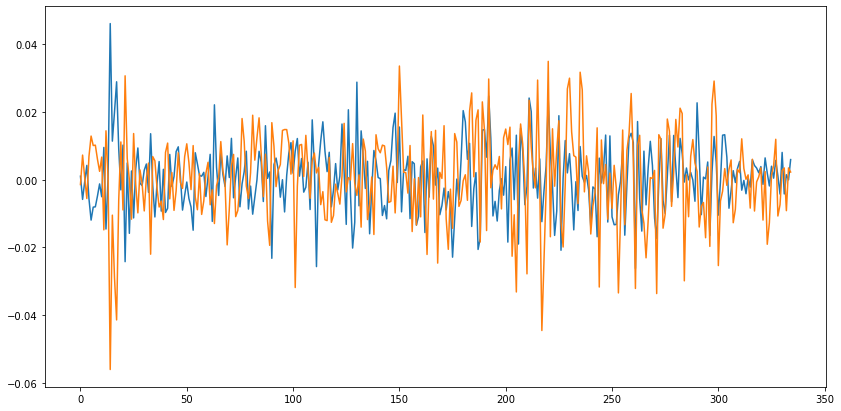

In [63]:
with open("/home/makiper/Notebooks/true_tree_rfls.pickle", "rb") as f:
    tree_rfls = pickle.load(f)
tree_rfls = tree_rfls['20220224'][:, indices]

timestep = 0
n = 2
fig = plt.figure(figsize=(14,7))
for i in range(n):
    recon = tree_rfls@this_1x_series[0]['eigen_vectors'][i:i+1].T@this_1x_series[0]['eigen_vectors'][i:i+1]
    plt.plot(np.mean(recon, axis=0), label="");

In [73]:
this_1x_series[0].keys()

dict_keys(['intrinsic_dimension', 'id_indicies', 'rhos', 'r', 'eigen_values', 'eigen_vectors'])

In [70]:
with open("/home/makiper/Notebooks/true_tree_rfls.pickle", "rb") as f:
    tree_rfls = pickle.load(f)
tree_rfls = tree_rfls['20220224'][:, indices]
    
# plt.plot(this_1x_series[0]['eigen_vectors'][0], label="");
print(tree_rfls.shape, this_1x_series[0]['eigen_vectors'][:1].shape)
recon = tree_rfls@this_1x_series[0]['eigen_vectors'][:1].T@this_1x_series[0]['eigen_vectors'][:1]
recon.shape

(1503, 335) (1, 335)


(1503, 335)

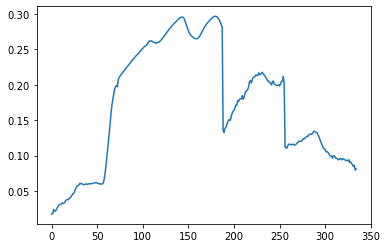

In [71]:
plt.plot(np.mean(tree_rfls, axis=0));

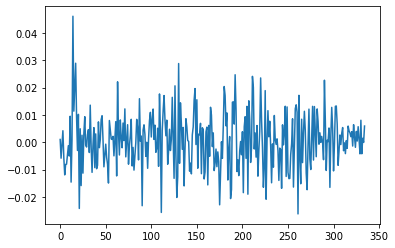

In [68]:
plt.plot(np.mean(recon, axis=0));

In [72]:
with open("/home/makiper/Notebooks/true_mining_rfls_corrected.pickle", "rb") as f:
    mining_rfls = pickle.load(f)

In [92]:
for k,v in mining_rfls.items():
    print(k, v.shape)

20220224 (2216, 425)
20220228 (2216, 425)
20220308 (2216, 425)
20220316 (2216, 425)
20220322 (0, 425)
20220405 (2216, 425)
20220412 (2216, 425)
20220420 (2216, 425)
20220429 (2216, 425)
20220503 (2216, 425)
20220511 (2216, 425)
20220517 (0, 425)
20220529 (2216, 425)


In [89]:
print(type(mining_rfls))

<class 'dict'>


In [90]:

np.savez("/home/makiper/Notebooks/phil_mining_rfls.npz", **mining_rfls)

In [35]:
rfls = mining_rfls['20220224']

In [36]:
for i, r in enumerate(rfls):
    rfls[i] = r/(sum([i**2 for i in r])**0.5)

In [31]:
intrinsic_dim = ID()
with open("/home/makiper/Notebooks/mining_noise_2.pickle", "rb") as f:
    m_noise = pickle.load(f)
corrected_noise = np.diag(m_noise)
this_n_est = {'noise_covariance':np.diag(corrected_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
this_n_est_10x = {'noise_covariance':np.diag(corrected_noise)*10, 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
this_n_est_100x = {'noise_covariance':np.diag(corrected_noise)*100, 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 

In [12]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indices = np.where(cond_1 | cond_2 | cond_3 | cond_4)
good_indices = [i for i in range(425) if i not in list(bad_indices[0])]

In [37]:
id_1x = intrinsic_dim(rfls, this_n_est)
id_10x = intrinsic_dim(rfls, this_n_est_10x)
id_100x = intrinsic_dim(rfls, this_n_est_100x)

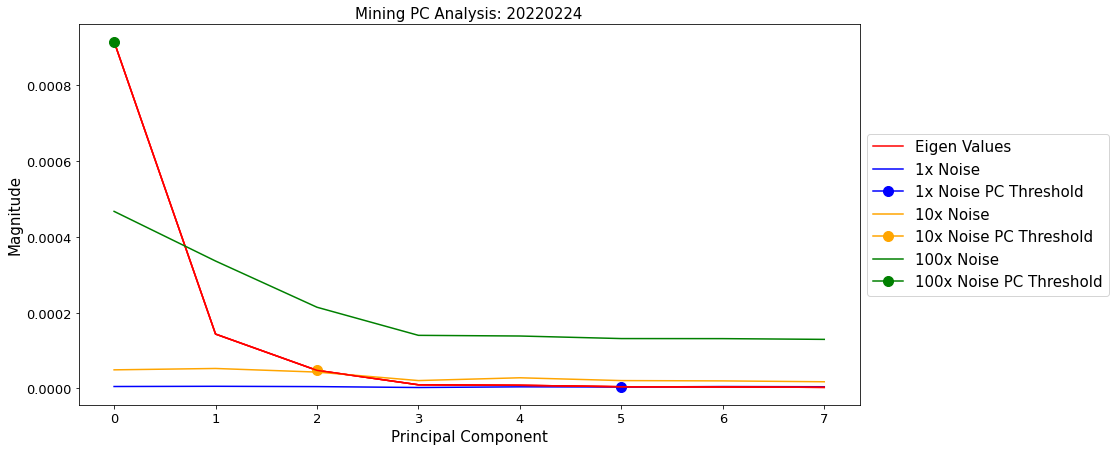

In [38]:
i = 0

this_1x_series = [id_1x]
this_10x_series = [id_10x]
this_100x_series = [id_100x]
title = "Mining"
date = ["20220224"][i]

threshold_1 = np.where(this_1x_series[i]['eigen_values'] < this_1x_series[i]['rhos']*this_1x_series[i]['r'])[0][0]
threshold_2 = np.where(this_10x_series[i]['eigen_values'] < this_10x_series[i]['rhos']*this_10x_series[i]['r'])[0][0]
threshold_3 = np.where(this_100x_series[i]['eigen_values'] < this_100x_series[i]['rhos']*this_100x_series[i]['r'])[0][0]
n = max(threshold_1, threshold_2, threshold_3) + 2

fig = plt.figure(figsize=(14,7))

plt.plot(this_1x_series[i]['eigen_values'][:n], color="red", label="Eigen Values"); # get the magnitudes
plt.plot(this_1x_series[i]['rhos'][:n]*this_1x_series[i]['r'], color="blue", label="1x Noise");
plt.plot(threshold_1-1, this_1x_series[i]['eigen_values'][threshold_1-1], marker="o", markersize=10, color="blue", label="1x Noise PC Threshold");

plt.plot(this_10x_series[i]['eigen_values'][:n], color="red"); # get the magnitudes
plt.plot(this_10x_series[i]['rhos'][:n]*this_10x_series[i]['r'], color="orange", label="10x Noise");
plt.plot(threshold_2-1, this_10x_series[i]['eigen_values'][threshold_2-1], marker="o", markersize=10, color="orange", label="10x Noise PC Threshold");

plt.plot(this_100x_series[i]['eigen_values'][:n], color="red"); # get the magnitudes
plt.plot(this_100x_series[i]['rhos'][:n]*this_100x_series[i]['r'], color="green", label="100x Noise");
plt.plot(threshold_3-1, this_100x_series[i]['eigen_values'][threshold_3-1], marker="o", markersize=10, color="green", label="100x Noise PC Threshold");

plt.xlabel("Principal Component", fontsize=15);
plt.ylabel("Magnitude", fontsize=15);
plt.xticks(range(0, n), fontsize=13);
plt.yticks(fontsize=13);
plt.title(f"{title} PC Analysis: {date}", fontsize=15);
plt.legend(fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5));

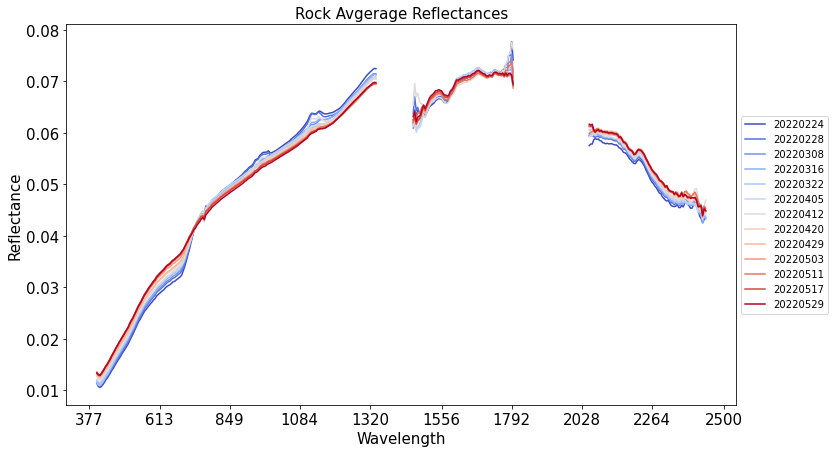

In [17]:
fig = plt.figure(figsize=(12,7))

with open("/home/makiper/Notebooks/true_rock_rfls.pickle", "rb") as f:
    tree_rfls = pickle.load(f)
    
this_series = tree_rfls
colors = plt.cm.coolwarm(np.linspace(0,1,len(list(this_series.keys()))))

for c_i, date in enumerate(this_series.keys()):
    this_rfls = this_series[date]
    this_rfls[:, bad_indices] = np.nan
    this_rfls = [i for i in this_rfls if -9999 not in list(i)]
    
    this_rfls = np.mean(this_rfls, axis=0)
    this_rfls_temp = this_rfls[good_indices]
    norm = sum([i**2 for i in this_rfls_temp])**0.5
    this_rfls = this_rfls/norm
    
    
    plt.plot(this_rfls, c = colors[c_i]);
    
#     ol = [distances[i][0] for i in range(len(z_scores)) if np.round(abs(z_scores[i]), 1) == t]
#     this_thresh_mean_rfl = np.array([parking_lot_dict[test_date][i] for i in ol])
    
#     if len(this_thresh_mean_rfl) == 0:
#         this_thresh_mean_rfl = np.zeros(425)
#         this_thresh_mean_rfl[bad_indicies] = np.nan
#     else:
#         this_thresh_mean_rfl = np.mean(this_thresh_mean_rfl, axis=0)
#         this_thresh_mean_rfl[bad_indicies] = np.nan
#         this_thresh_mean_rfl = this_thresh_mean_rfl/(sum([i**2 for i in this_thresh_mean_rfl if not np.isnan(i)])**0.5)
#     plt.plot(this_thresh_mean_rfl, c = colors[c_i]);


plt.title("Rock Avgerage Reflectances", fontsize=15);
plt.xlabel("Wavelength", fontsize=15);
plt.ylabel("Reflectance", fontsize=15);
n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]
plt.xticks(x_t0, x_t1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend([str(t) for t in this_series.keys()], loc='center left', bbox_to_anchor=(1, 0.5));

In [13]:
kerry_noise = open("/home/makiper/Notebooks/SHIFT_noise_M_allbands_2.txt", "rb").read()
kerry_noise = str(kerry_noise).replace("b","").replace("'", "")
kerry_noise = np.array([float(i) for i in str(kerry_noise).split(",") if i != ''])

np.where(np.round(kerry_noise,8) == np.round(2.5611722819684514e-05, 8))

(array([421]),)

In [5]:
t = pickle.load(open("/home/makiper/Clustering/v3/unsupervised_test_rfls.pickle", "rb"))

In [6]:
t

{'20220224': array([], shape=(0, 425), dtype=float32),
 '20220228': array([], shape=(0, 425), dtype=float32),
 '20220308': array([], shape=(0, 425), dtype=float32),
 '20220316': array([], shape=(0, 425), dtype=float32),
 '20220322': array([], shape=(0, 425), dtype=float32),
 '20220405': array([], shape=(0, 425), dtype=float32),
 '20220412': array([], shape=(0, 425), dtype=float32),
 '20220420': array([], shape=(0, 425), dtype=float32),
 '20220429': array([], shape=(0, 425), dtype=float32),
 '20220503': array([], shape=(0, 425), dtype=float32),
 '20220511': array([], shape=(0, 425), dtype=float32),
 '20220517': array([], shape=(0, 425), dtype=float32),
 '20220529': array([], shape=(0, 425), dtype=float32)}

In [7]:
os.listdir("/home/makiper/Clustering/v3/")

['us_3.shp',
 'us_3.shx',
 'us_3.prj',
 'us_3.dbf',
 'us_3.geojson',
 'slurm-296410.out',
 'cover_raster_unsupervised_test.tif',
 'cover_extraction_unsupervised_test.csv',
 'unsupervised_test_rfls.pickle']

In [ ]:
print("here")

In [6]:
from spectral.io import envi

In [25]:
dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
rfls = {}
for date in dates:
    try:
        file = f"/beegfs/scratch/brodrick/shift/analyses/noise_matrix/glint_retrievals/{date}/output/box_rfl_phase_water_rfl"
        rfl = envi.open(file + '.hdr').open_memmap(interleave='bip').copy()
        rfl = np.transpose(rfl, (1,0,2))
        rfls[date] = rfl
    except Exception as e:
        print(f"Error at {date}")
        continue

spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.


Error at 20220322
Error at 20220420


spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.


In [26]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indices = np.where(cond_1 | cond_2 | cond_3 | cond_4)
good_indices = [i for i in range(425) if i not in list(bad_indices[0])]

In [27]:
for key, rfl in rfls.items():
    rfls[key] = np.array(rfl)[:, :, good_indices]
    print(rfls[key].shape)

(160, 155, 335)
(160, 155, 335)
(160, 155, 335)
(160, 155, 335)
(160, 155, 335)
(160, 155, 335)
(160, 155, 335)
(160, 155, 335)
(160, 155, 335)
(160, 155, 335)
(160, 155, 335)


In [28]:
for key, rfl in rfls.items():
    rfls[key] = np.reshape(rfl, (rfl.shape[0]*rfl.shape[1], rfl.shape[2]))
    print(rfls[key].shape)

(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)


In [29]:
for key, rfl in rfls.items():
    rfls[key] = np.delete(rfl, [i for i, r in enumerate(rfl) if 0 in r], axis=0)
    print(rfls[key].shape)

(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)


In [101]:
rfls_backup = rfls.copy()

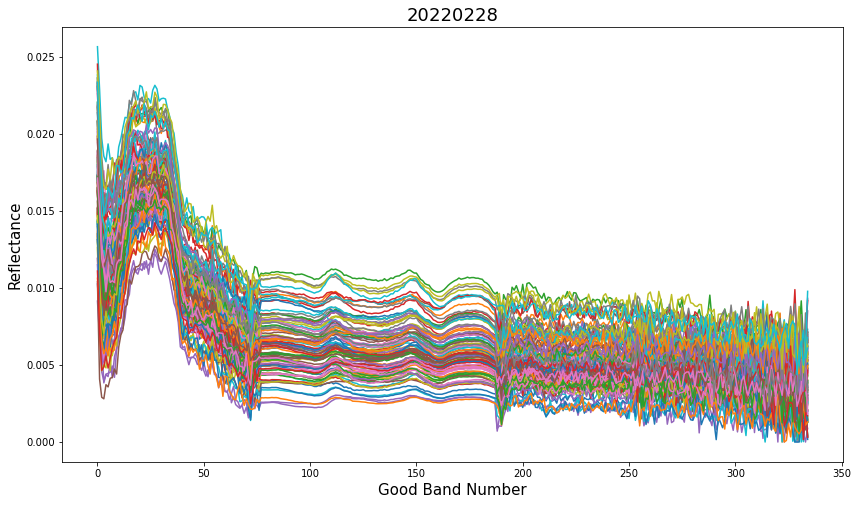

In [102]:
date = dates[1]

rfl = rfls[date]

n = 100

fig = plt.figure(figsize=(14,8))
for i in range(n):
    x = np.random.randint(rfl.shape[0])
    plt.plot(rfl[x], label=str(i))
    
plt.xlabel("Good Band Number", fontsize=15);
plt.ylabel("Reflectance", fontsize=15);
plt.title(str(date), fontsize=18);
# plt.legend();

In [103]:
def spectral_angle(a, b):
    a, b = np.array(a), np.array(b)
    if a.shape != b.shape:
        raise Exception("shape mismatch")
        
    def l2_norm(x):
        return sum([i**2 for i in x])**0.5
    
    inner = (a.T@b)/(l2_norm(a)*l2_norm(b))
    return np.arccos(inner)

distance_dict = {}
for date in rfls.keys():
    print(f"Running date: {date}")
    # GET DISTANCES
    ds = rfls[date]
    distances = []

    # normalize
    mean = np.mean(ds, axis=0)
    std = np.std(ds, axis=0)

    for i, pix in enumerate(ds):
        dist = spectral_angle(mean, pix) # normalization happens within spectral angle
        distances.append((i, dist))
        
    distance_dict[date] = distances

In [104]:
zscore_dict = {}

for date in rfls.keys():
    distances = distance_dict[date]
    mean_dist = np.mean([m[1] for m in distances])
    std_dist = np.nanstd([m[1] for m in distances])
    print(mean_dist, std_dist)

    # z_scores = [abs((d[1]-mean_dist))/std_dist for d in distances]
    z_scores = [d[1] for d in distances]
    zscore_dict[date] = z_scores

0.08576723904329116 0.0285549812525002
0.13903105053705314 0.10102826343706277
0.328233866521202 0.08268029393728912
0.08674222958728753 0.05569228548827685
0.08698301020360225 0.040287283164982785
0.06482735728366976 0.06121968857361234
0.11129972424933139 0.0657178859787965
0.10643195940952853 0.06162743529943548
0.14164233907886079 0.08459656272513491
0.10469080651560825 0.07482718758137105
0.08421990936740843 0.08469950316536617


In [256]:
i = 10
time = list(rfls.keys())[i]

In [257]:
threshold = 0.5
distances = distance_dict[time]
z_scores = zscore_dict[time]
outliers = [distances[i][0] for i in range(len(z_scores)) if abs(z_scores[i])>threshold]
print(f"Outliers: {len(outliers)} | Total Pixels: {len(z_scores)} | Usable Pixels: {len(z_scores)-len(outliers)}")

Outliers: 8 | Total Pixels: 24800 | Usable Pixels: 24792


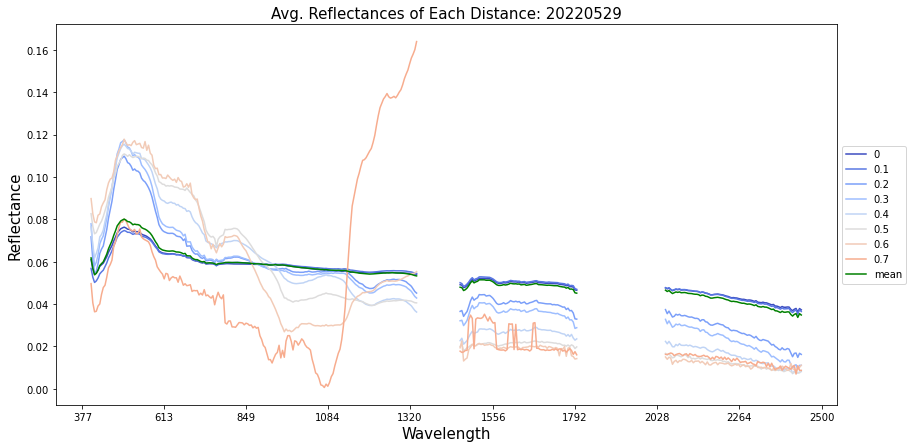

In [258]:
threshes = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
# threshes = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
# threshes = [0, 0.2, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2]
# threshes = [0.7, 0.8, 0.9, 1, 1.1, 1.2]
threshes = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# threshes = [2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3]
fig = plt.figure(figsize=(14,7))

colors = plt.cm.coolwarm(np.linspace(0,1,len(threshes)))

for c_i, t in enumerate(threshes):
    ol = [distances[i][0] for i in range(len(z_scores)) if np.round(abs(z_scores[i]), 1) == t]
    this_thresh_mean_rfl = np.array([rfls_backup[time][i] for i in ol])
    
    # if len(this_thresh_mean_rfl) == 0:
    #     this_thresh_mean_rfl = np.zeros(335)
    if len(this_thresh_mean_rfl) != 0:
        this_thresh_mean_rfl = np.mean(this_thresh_mean_rfl, axis=0)
        this_thresh_mean_rfl = this_thresh_mean_rfl/(sum([i**2 for i in this_thresh_mean_rfl])**0.5)
        
        plt_rfl = []
        index = 0
        for i in range(425):
            if i in good_indices:
                plt_rfl.append(this_thresh_mean_rfl[index])
                index += 1
            else:
                plt_rfl.append(np.nan)
                
        plt.plot(plt_rfl, c = colors[c_i], label=str(t));

sm = np.array(np.mean(rfls_backup[time], axis=0)/(sum([i**2 for i in np.mean(rfls_backup[time], axis=0)])**0.5))
plt_rfl = []
index = 0
for i in range(425):
    if i in good_indices:
        plt_rfl.append(sm[index])
        index += 1
    else:
        plt_rfl.append(np.nan)
        
plt.plot(plt_rfl, c='green', label="mean");

n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]
plt.xticks(x_t0, x_t1)

plt.title(f"Avg. Reflectances of Each Distance: {time}", fontsize=15);
plt.xlabel("Wavelength", fontsize=15);
plt.ylabel("Reflectance", fontsize=15);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [114]:
print(rfls[time].shape)
rfls[time] = np.delete(rfls[time], outliers, axis=0)
print(rfls[time].shape)

(24800, 335)
(24797, 335)


In [287]:
pickle.dump(rfls_backup, open("/home/makiper/Notebooks/water_rfls.pickle", "wb"))

In [299]:
total_rfls = None
for date, rfl in rfls_backup.items():
    if total_rfls is None:
        total_rfls = rfl
    else:
        total_rfls = np.concatenate([total_rfls, rfl], axis=0)
total_rfls.shape

(246567, 335)

In [300]:
total_rfls = total_rfls[:246560, :]
total_rfls.shape

(246560, 335)

In [302]:
total_rfls = np.reshape(total_rfls, (536, 460, 335))
total_rfls.shape

(536, 460, 335)

In [303]:
pickle.dump(total_rfls, open("/home/makiper/Notebooks/water_rfls_total.pickle", "wb"))

In [5]:
from spectral.io import envi

In [6]:
dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
temp_rfls = {}
for date in dates:
    try:
        file = f"/beegfs/scratch/brodrick/shift/analyses/noise_matrix/glint_retrievals/{date}/output/box_state_phase_water_state"
        rfl = envi.open(file + '.hdr').open_memmap(interleave='bip').copy()
        rfl = np.transpose(rfl, (1,0,2))
        temp_rfls[date] = rfl
    except Exception as e:
        print(f"Error at {date}")
        continue

spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.


Error at 20220322
Error at 20220420


spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.


In [7]:
temp_rfls[dates[0]].shape

(160, 155, 429)

In [13]:
glints = {}
overall_glints = []
for date, rfl in temp_rfls.items():
    glint = []
    for x in range(rfl.shape[0]):
        for y in range(rfl.shape[1]):
            glint.append(rfl[x][y][-3])
            overall_glints.append(rfl[x][y][-3])
            
    glints[date] = glint

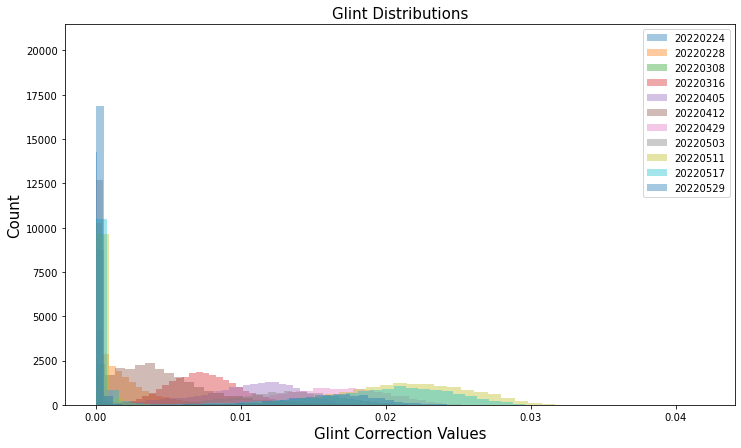

In [14]:
fig = plt.figure(figsize=(12, 7))
for date, g in glints.items():
    plt.hist(g, bins=45, label=date, alpha=0.4);
    
plt.title("Glint Distributions", fontsize=15);
plt.xlabel("Glint Correction Values", fontsize=15);
plt.ylabel("Count", fontsize=15);
plt.legend();

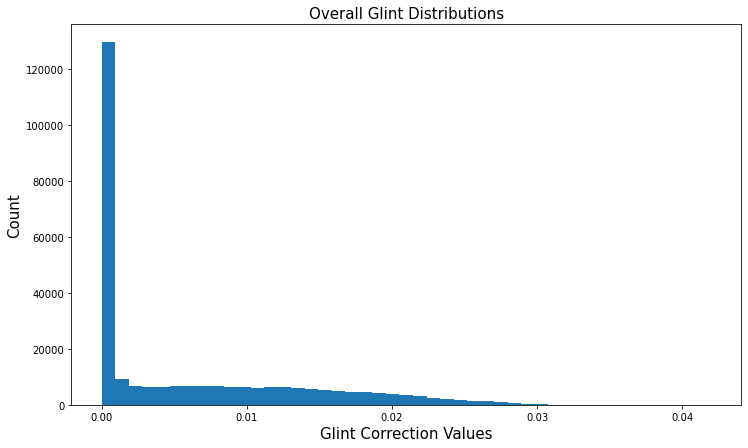

In [15]:
fig = plt.figure(figsize=(12, 7))
plt.hist(overall_glints, bins=45);
plt.title("Overall Glint Distributions", fontsize=15);
plt.xlabel("Glint Correction Values", fontsize=15);
plt.ylabel("Count", fontsize=15);

In [16]:
for date, g in glints.items():
    print(f"{date} | Number of 0 values: {np.count_nonzero(g==0)} | max: {max(g)} | min: {min(g)}")

20220224 | Number of 0 values: 0 | max: 0.0033681578934192657 | min: 2.313539354986289e-20
20220228 | Number of 0 values: 0 | max: 0.020689569413661957 | min: 2.5254341053908286e-40
20220308 | Number of 0 values: 0 | max: 0.0013795307604596019 | min: 1.4464131889890526e-20
20220316 | Number of 0 values: 0 | max: 0.020753558725118637 | min: 7.838093113475056e-29
20220405 | Number of 0 values: 0 | max: 0.021846666932106018 | min: 4.954252340403503e-14
20220412 | Number of 0 values: 0 | max: 0.030549246817827225 | min: 1.073059507916696e-08
20220429 | Number of 0 values: 0 | max: 0.02698473259806633 | min: 4.5372161583401294e-10
20220503 | Number of 0 values: 0 | max: 0.024346141144633293 | min: 5.19392168163435e-12
20220511 | Number of 0 values: 0 | max: 0.04195990785956383 | min: 1.106672045669832e-10
20220517 | Number of 0 values: 0 | max: 0.03700888901948929 | min: 2.7918628520140487e-10
20220529 | Number of 0 values: 0 | max: 0.027245748788118362 | min: 4.334032793567276e-14


In [280]:
t = "RFL_0377 , RFL_0382 , RFL_0387 , RFL_0392 , RFL_0397 , RFL_0402 , RFL_0407 , RFL_0412 , RFL_0417 , RFL_0422 , RFL_0427 , RFL_0432 , RFL_0437 , RFL_0442 , RFL_0447 , RFL_0452 , RFL_0457 , RFL_0462 , RFL_0467 , RFL_0472 , RFL_0477 , RFL_0482 , RFL_0487 , RFL_0492 , RFL_0497 , RFL_0502 , RFL_0507 , RFL_0512 , RFL_0517 , RFL_0522 , RFL_0527 , RFL_0532 , RFL_0537 , RFL_0542 , RFL_0547 , RFL_0552 , RFL_0557 , RFL_0562 , RFL_0567 , RFL_0572 , RFL_0577 , RFL_0582 , RFL_0587 , RFL_0592 , RFL_0597 , RFL_0602 , RFL_0607 , RFL_0612 , RFL_0617 , RFL_0622 , RFL_0627 , RFL_0632 , RFL_0637 , RFL_0642 , RFL_0647 , RFL_0652 , RFL_0657 , RFL_0662 , RFL_0667 , RFL_0672 , RFL_0677 , RFL_0682 , RFL_0687 , RFL_0692 , RFL_0697 , RFL_0702 , RFL_0707 , RFL_0712 , RFL_0717 , RFL_0722 , RFL_0727 , RFL_0732 , RFL_0737 , RFL_0742 , RFL_0747 , RFL_0752 , RFL_0757 , RFL_0762 , RFL_0767 , RFL_0772 , RFL_0777 , RFL_0782 , RFL_0787 , RFL_0792 , RFL_0797 , RFL_0802 , RFL_0807 , RFL_0812 , RFL_0817 , RFL_0822 , RFL_0827 , RFL_0832 , RFL_0837 , RFL_0843 , RFL_0848 , RFL_0853 , RFL_0858 , RFL_0863 , RFL_0868 , RFL_0873 , RFL_0878 , RFL_0883 , RFL_0888 , RFL_0893 , RFL_0898 , RFL_0903 , RFL_0908 , RFL_0913 , RFL_0918 , RFL_0923 , RFL_0928 , RFL_0933 , RFL_0938 , RFL_0943 , RFL_0948 , RFL_0953 , RFL_0958 , RFL_0963 , RFL_0968 , RFL_0973 , RFL_0978 , RFL_0983 , RFL_0988 , RFL_0993 , RFL_0998 , RFL_1003 , RFL_1008 , RFL_1013 , RFL_1018 , RFL_1023 , RFL_1028 , RFL_1033 , RFL_1038 , RFL_1043 , RFL_1048 , RFL_1053 , RFL_1058 , RFL_1063 , RFL_1068 , RFL_1073 , RFL_1078 , RFL_1083 , RFL_1088 , RFL_1093 , RFL_1098 , RFL_1103 , RFL_1108 , RFL_1113 , RFL_1118 , RFL_1123 , RFL_1128 , RFL_1133 , RFL_1138 , RFL_1143 , RFL_1148 , RFL_1153 , RFL_1158 , RFL_1163 , RFL_1168 , RFL_1173 , RFL_1178 , RFL_1183 , RFL_1188 , RFL_1193 , RFL_1198 , RFL_1203 , RFL_1208 , RFL_1213 , RFL_1218 , RFL_1223 , RFL_1228 , RFL_1233 , RFL_1238 , RFL_1243 , RFL_1248 , RFL_1253 , RFL_1258 , RFL_1263 , RFL_1268 , RFL_1273 , RFL_1278 , RFL_1283 , RFL_1288 , RFL_1293 , RFL_1298 , RFL_1303 , RFL_1308 , RFL_1313 , RFL_1318 , RFL_1323 , RFL_1328 , RFL_1333 , RFL_1338 , RFL_1343 , RFL_1348 , RFL_1353 , RFL_1358 , RFL_1363 , RFL_1368 , RFL_1373 , RFL_1378 , RFL_1383 , RFL_1388 , RFL_1393 , RFL_1398 , RFL_1403 , RFL_1408 , RFL_1413 , RFL_1418 , RFL_1424 , RFL_1429 , RFL_1434 , RFL_1439 , RFL_1444 , RFL_1449 , RFL_1454 , RFL_1459 , RFL_1464 , RFL_1469 , RFL_1474 , RFL_1479 , RFL_1484 , RFL_1489 , RFL_1494 , RFL_1499 , RFL_1504 , RFL_1509 , RFL_1514 , RFL_1519 , RFL_1524 , RFL_1529 , RFL_1534 , RFL_1539 , RFL_1544 , RFL_1549 , RFL_1554 , RFL_1559 , RFL_1564 , RFL_1569 , RFL_1574 , RFL_1579 , RFL_1584 , RFL_1589 , RFL_1594 , RFL_1599 , RFL_1604 , RFL_1609 , RFL_1614 , RFL_1619 , RFL_1624 , RFL_1629 , RFL_1634 , RFL_1639 , RFL_1644 , RFL_1649 , RFL_1654 , RFL_1659 , RFL_1664 , RFL_1669 , RFL_1674 , RFL_1679 , RFL_1684 , RFL_1689 , RFL_1694 , RFL_1699 , RFL_1704 , RFL_1709 , RFL_1714 , RFL_1719 , RFL_1724 , RFL_1729 , RFL_1734 , RFL_1739 , RFL_1744 , RFL_1749 , RFL_1754 , RFL_1759 , RFL_1764 , RFL_1769 , RFL_1774 , RFL_1779 , RFL_1784 , RFL_1789 , RFL_1794 , RFL_1799 , RFL_1804 , RFL_1809 , RFL_1814 , RFL_1819 , RFL_1824 , RFL_1829 , RFL_1834 , RFL_1839 , RFL_1844 , RFL_1849 , RFL_1854 , RFL_1859 , RFL_1864 , RFL_1869 , RFL_1874 , RFL_1879 , RFL_1884 , RFL_1889 , RFL_1894 , RFL_1899 , RFL_1904 , RFL_1909 , RFL_1914 , RFL_1919 , RFL_1924 , RFL_1929 , RFL_1934 , RFL_1939 , RFL_1944 , RFL_1949 , RFL_1954 , RFL_1959 , RFL_1964 , RFL_1969 , RFL_1974 , RFL_1979 , RFL_1984 , RFL_1989 , RFL_1994 , RFL_2000 , RFL_2005 , RFL_2010 , RFL_2015 , RFL_2020 , RFL_2025 , RFL_2030 , RFL_2035 , RFL_2040 , RFL_2045 , RFL_2050 , RFL_2055 , RFL_2060 , RFL_2065 , RFL_2070 , RFL_2075 , RFL_2080 , RFL_2085 , RFL_2090 , RFL_2095 , RFL_2100 , RFL_2105 , RFL_2110 , RFL_2115 , RFL_2120 , RFL_2125 , RFL_2130 , RFL_2135 , RFL_2140 , RFL_2145 , RFL_2150 , RFL_2155 , RFL_2160 , RFL_2165 , RFL_2170 , RFL_2175 , RFL_2180 , RFL_2185 , RFL_2190 , RFL_2195 , RFL_2200 , RFL_2205 , RFL_2210 , RFL_2215 , RFL_2220 , RFL_2225 , RFL_2230 , RFL_2235 , RFL_2240 , RFL_2245 , RFL_2250 , RFL_2255 , RFL_2260 , RFL_2265 , RFL_2270 , RFL_2275 , RFL_2280 , RFL_2285 , RFL_2290 , RFL_2295 , RFL_2300 , RFL_2305 , RFL_2310 , RFL_2315 , RFL_2320 , RFL_2325 , RFL_2330 , RFL_2335 , RFL_2340 , RFL_2345 , RFL_2350 , RFL_2355 , RFL_2360 , RFL_2365 , RFL_2370 , RFL_2375 , RFL_2380 , RFL_2385 , RFL_2390 , RFL_2395 , RFL_2400 , RFL_2405 , RFL_2410 , RFL_2415 , RFL_2420 , RFL_2425 , RFL_2430 , RFL_2435 , RFL_2440 , RFL_2445 , RFL_2450 , RFL_2455 , RFL_2460 , RFL_2465 , RFL_2470 , RFL_2475 , RFL_2480 , RFL_2485 , RFL_2490 , RFL_2495 , RFL_2500 , SURF_TEMP_K , GLINT , AOT550 , H2OSTR"

In [281]:
len(t.split(" , "))

429

In [283]:
t.split(" , ")[-3]

'GLINT'

In [5]:
from spectral.io import envi

In [6]:
dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
temp_rfls = {}
for date in dates:
    try:
        file = f"/beegfs/scratch/brodrick/shift/analyses/noise_matrix/glint_retrievals/{date}/output/box_rfl_phase_water_rfl"
        rfl = envi.open(file + '.hdr').open_memmap(interleave='bip').copy()
        rfl = np.transpose(rfl, (1,0,2))
        temp_rfls[date] = rfl
    except Exception as e:
        print(f"Error at {date}")
        continue
        
temp_rfls[dates[0]].shape

spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.


Error at 20220322
Error at 20220420


spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.
spectral:WARNING: Unable to parse bad band list (bbl) in ENVI header as integers.


(160, 155, 425)

In [23]:
dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
v1_rfls = {}
for date in dates:
    try:
        file = f"/beegfs/scratch/brodrick/shift/analyses/noise_matrix/kiper_subsets/{date}/subset_rfl"
        rfl = envi.open(file + '.hdr').open_memmap(interleave='bip').copy()
        rfl = np.transpose(rfl, (1,0,2))
        v1_rfls[date] = rfl
    except Exception as e:
        print(f"Error at {date}")
        continue
        
v1_rfls[dates[0]].shape

Error at 20220322


(160, 155, 425)

In [7]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indices = np.where(cond_1 | cond_2 | cond_3 | cond_4)
good_indices = [i for i in range(425) if i not in list(bad_indices[0])]

In [25]:
for key, rfl in v1_rfls.items():
    v1_rfls[key] = np.array(rfl)[:, :, good_indices]
    v1_rfls[key] = np.reshape(v1_rfls[key], (v1_rfls[key].shape[0]*v1_rfls[key].shape[1], v1_rfls[key].shape[2]))
    v1_rfls[key] = np.delete(v1_rfls[key], [i for i, r in enumerate(v1_rfls[key]) if 0 in r], axis=0)
    print(v1_rfls[key].shape)

(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(0, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)
(24800, 335)


In [8]:
#compare to new rfls
for key, rfl in temp_rfls.items():
    temp_rfls[key] = np.array(rfl)[:, :, good_indices]
    print(temp_rfls[key].shape)
    temp_rfls[key] = np.reshape(temp_rfls[key], (temp_rfls[key].shape[0]*temp_rfls[key].shape[1], temp_rfls[key].shape[2]))
    temp_rfls[key] = np.delete(temp_rfls[key], [i for i, r in enumerate(temp_rfls[key]) if 0 in r], axis=0)
    print(temp_rfls[key].shape)

(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)
(160, 155, 335)
(24800, 335)


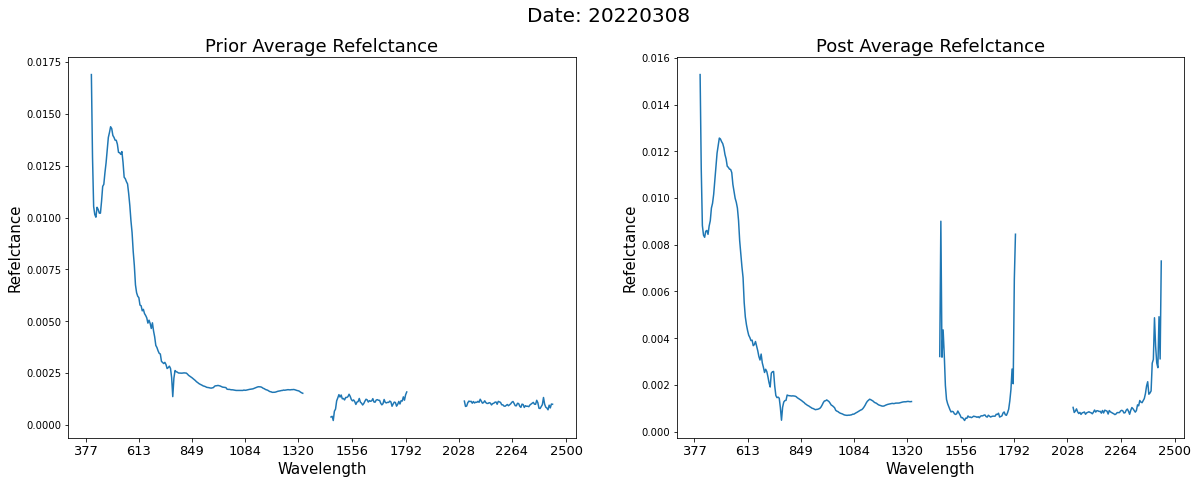

In [27]:
time = 2
date = list(temp_rfls.keys())[time]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7));
fig.suptitle(f'Date: {date}', fontsize=20);

n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]

mean1 = np.mean(v1_rfls[date], axis=0)
plt_rfl1 = []
index = 0
for i in range(425):
    if i in good_indices:
        plt_rfl1.append(mean1[index])
        index += 1
    else:
        plt_rfl1.append(np.nan)
ax1.plot(plt_rfl1);
ax1.set_title("Prior Average Refelctance", fontsize=18);
ax1.set_xlabel("Wavelength", fontsize=15);
ax1.set_ylabel("Refelctance", fontsize=15);
ax1.set_xticks(x_t0, x_t1, fontsize=13);

mean2 = np.mean(temp_rfls[date], axis=0)
plt_rfl2 = []
index = 0
for i in range(425):
    if i in good_indices:
        plt_rfl2.append(mean2[index])
        index += 1
    else:
        plt_rfl2.append(np.nan)
ax2.plot(plt_rfl2);
ax2.set_title("Post Average Refelctance", fontsize=18);
ax2.set_xlabel("Wavelength", fontsize=15);
ax2.set_ylabel("Refelctance", fontsize=15);
ax2.set_xticks(x_t0, x_t1, fontsize=13);

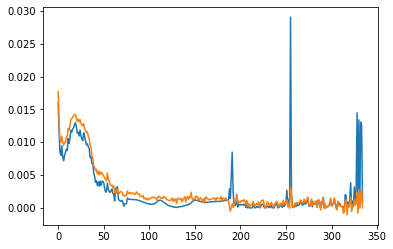

In [28]:
i = 4
plt.plot(temp_rfls[date][i]) ;
plt.plot(v1_rfls[date][i]);

In [9]:
total_rfls = []
for key, rfl in temp_rfls.items():
    # rfl = np.reshape(rfl, (160, 155, 335))
    if len(total_rfls) == 0:
        total_rfls = rfl
    else:
        total_rfls = np.concatenate([total_rfls, rfl], axis=0)
        
# total_rfls = np.reshape(total_rfls, (800, 341, 335))
total_rfls.shape

(272800, 335)

In [41]:
pickle.dump(total_rfls, open("/home/makiper/Notebooks/water_rfls_total.pickle", "wb"))

In [124]:
average = np.average(temp_rfls['20220224'], axis = 0)
cov_original = np.cov(total_rfls, rowvar=False)

filterd_total_rfls = total_rfls-average

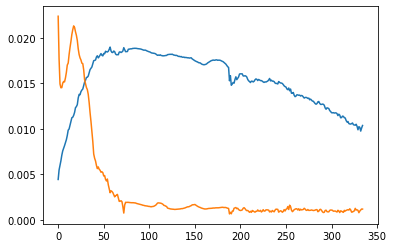

In [125]:
plt.plot(np.average(filterd_total_rfls, axis=0));
plt.plot(average);

In [126]:
# plt.plot(np.diag(cov_filter));

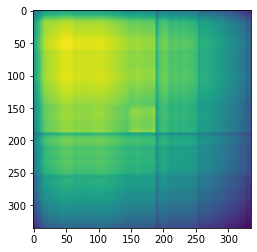

In [137]:
plt.imshow(cov_original);

In [128]:
pc_original =  np.linalg.eig(cov_original)
# pc_filter = np.linalg.eig(cov_filter)

In [129]:
vals_original = pc_original[0][np.argsort(pc_original[0])[::-1]]
vecs_original = pc_original[1][np.argsort(pc_original[0])[::-1]]

# vals_filter = pc_filter[0][np.argsort(pc_filter[0])[::-1]]
# vecs_filter = pc_filter[1][np.argsort(pc_filter[0])[::-1]]

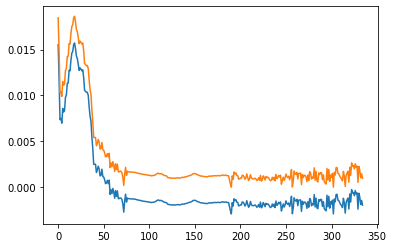

In [152]:
plt.plot((total_rfls.T-np.average(total_rfls, axis=1)).T[0]);
plt.plot(total_rfls[0]);

In [163]:
representation = (filterd_total_rfls@vecs_original)
# representation = ((total_rfls.T-np.average(total_rfls, axis=1)).T@vecs_original)
# filtered_rep = representation-average
filtered_rep = representation-np.average(representation, axis=0)

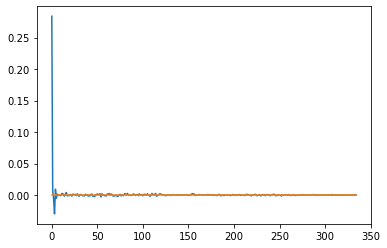

In [164]:
plt.plot(np.average(representation, axis=0));
plt.plot(np.average(filtered_rep, axis=0));

In [160]:
cov_filter = np.cov(filtered_rep, rowvar=False)
pc_filter = np.linalg.eig(cov_filter)
vals_filter = pc_filter[0][np.argsort(pc_filter[0])[::-1]]
vecs_filter = pc_filter[1][np.argsort(pc_filter[0])[::-1]]

In [143]:
noise = representation-filtered_rep

[]


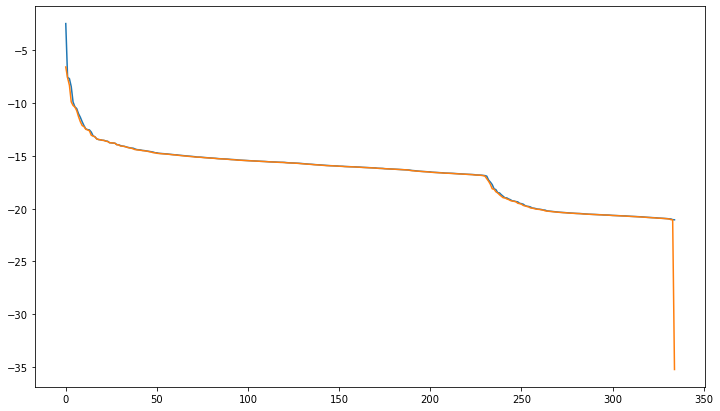

In [165]:
fig = plt.figure(figsize=(12, 7))
ev_original = np.log(sorted(pc_original[0], reverse=True))
ev_filtered = np.log(sorted(pc_filter[0], reverse=True))
plt.plot(ev_original);
plt.plot(ev_filtered);
print(np.where(ev_original-ev_filtered <0)[0])

In [10]:
noise = total_rfls-np.mean(total_rfls, axis=0)

In [11]:
noise = np.diag(np.cov(noise, rowvar=False))

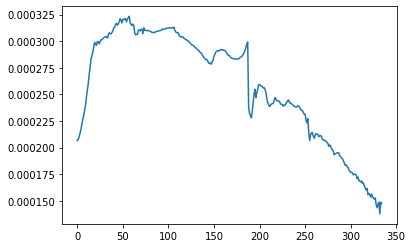

In [12]:
plt.plot(noise);

In [13]:
pickle.dump(noise, open("/home/makiper/Notebooks/water_noise.pickle", "wb"))